In [ ]:
# This is research code I compliled for analysis of ptychography images reconstructed with PtyPy (https://ptycho.github.io/ptypy/)
# specifically for data collected at i08-1 beamline of the Diamond Light Source and is by no means complete. This is however not 
# limited to just ptycho reconstructions but can in general be used for analysis of images. Some parts of the code may use CPU 
# parallelization routines. I do not hold any responsiblity and liability for the use of this code. Feel free to modify and edit this code to your usecase.
# Questions, suggestions and bugs can be reported to jeffrey.neethirajan@cpfs.mpg.de (or stalk me in the internet ;))

## Importing modules

In [1]:
%reset -f
import os
import skimage
import h5py
import time
import pynx
import imageio
import glob
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter
from scipy.constants import h, c, pi, e, hbar, physical_constants
from skimage.registration import phase_cross_correlation
from skimage.segmentation import chan_vese
from skimage.filters import threshold_multiotsu
from scipy.ndimage import fourier_shift
from pynx.utils import fourier_shell_correlation
from ptypy.utils.plot_utils import rmphaseramp
from joblib import Parallel, delayed
from scipy.optimize import curve_fit
from ipywidgets import interactive

## Define frequently used functions

In [2]:
""" Adapt this section for the needs of the analysis
    Might also contain a few bugs"""




os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
plt.rcParams["figure.figsize"] = (8, 6)

def plot_img(data, y_range=(0, -1), x_range=(0, -1), cmap='RdBu', threshold=(None, None), title = None):
    """ Function to plot an image """
    %matplotlib inline
    plt.close()
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    im1 = ax1.imshow(data[y_range[0]:y_range[1], x_range[0]:x_range[1]], cmap=cmap, vmin=threshold[0], vmax=threshold[-1])
    # plt.axvline(200, color = 'g')
    if title != None:
        ax1.set_title(title)
    plt.colorbar(im1, ax=ax1)
    plt.show()
    plt.close()

def single_plot_img(data, y_range=(0, -1), x_range=(0, -1), cmap='RdBu', threshold=(None, None), title = None):
    """ Function to plot an image """
    %matplotlib widget
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    im1 = ax1.imshow(data[y_range[0]:y_range[1], x_range[0]:x_range[1]], cmap=cmap, vmin=threshold[0], vmax=threshold[-1])
    if title != None:
        ax1.set_title(title)
    plt.colorbar(im1, ax=ax1)
    plt.ioff()
    plt.show()


def crop_img(data, y_range=(0, -1), x_range=(0, -1), num_of_img=1):
    """ Function to crop array (images) """
    cropped_img = []
    for i in range(0, num_of_img):
        y = data[i][y_range[0]:y_range[1], x_range[0]:x_range[-1]]
        cropped_img.append(y)
    return np.array(cropped_img)

def alignment(data, reference,num_of_img=1):
    """ Function to align two images. Sub-pixel image registration is done. Shifts are applied in Fourier Space.
    Returns aligned image and the shift applied """
    aligned_image = []
    shifts = []
    if num_of_img==1:
        s, error, diffphase = phase_cross_correlation(reference_image=reference, moving_image=data, upsample_factor=50, space='real')
        fft_img = np.fft.fftn(data)
        r = fourier_shift(fft_img, s)
        real_img = np.fft.ifftn(r)
        aligned_image.append(real_img)
        shifts.append(s)
    elif num_of_img>1:
        for i in range (0, num_of_img):
            s, error, diffphase = phase_cross_correlation(reference_image=reference, moving_image=data[i], upsample_factor=50, space='real')
            fft_img = np.fft.fftn(data[i])
            r = fourier_shift(fft_img, s)
            real_img = np.fft.ifftn(r)
            aligned_image.append(real_img)
            shifts.append(s)
    return aligned_image, shifts   #changed np.asarray

def norm(data, y_range=(0,-1), x_range=(0,-1), num_of_img=1, dtype='amplitude'):
    """ Function to normalise data """
    norm_factor = []
    norm_data = []
    if num_of_img == 1:
        n = np.average(data[y_range[0]:y_range[1], x_range[0]:x_range[1]])
        norm_factor = n
        if dtype=='amplitude':
            return data / norm_factor
        else:
            return data - norm_factor
    elif num_of_img>1:
        for i in range (0, num_of_img):
            n = np.average(data[i][y_range[0]:y_range[1], x_range[0]:x_range[1]])
            # norm_factor.append(n)
            if dtype == 'amplitude':
                a = data[i] / n
                norm_data.append(a)
            elif dtype == 'phase':
                a = data[i] - n
                norm_data.append(a)
        return np.array(norm_data)    

def local_threshold(data, std_weight_factor=2):
    """ Function returns threshold values based on average and standard deviation """
    w1 = np.average(data)
    w2 = np.std(data)
    return w1 - std_weight_factor*w2, w1 + std_weight_factor*w2

def remove_phase_ramp(data, mask, num_of_img=1):
    """ Function to remove phase ramp"""
    if num_of_img == 1:
        q1 = rmphaseramp(data, weight=mask)
    else:
        q1 = [rmphaseramp(data[i], weight=mask) for i in range (0, num_of_img)]
    return np.asarray(q1)

def segmentation(data, y_range=(0, -1), x_range=(0, -1), circle=True, circle_y_range=(75, 100), circle_x_range=(25, 50)):
    """ Function to segment an image based on the chan vese algorithm. Can only be applied on arrays with real values"""
    labels = chan_vese(data[y_range[0]:y_range[1], x_range[0]:x_range[1]], mu=0.05, init_level_set='checkerboard', dt=0.5)
    if circle==True:
        if np.average(labels[circle_y_range[0]:circle_y_range[1], circle_x_range[0]:circle_x_range[1]])==1:
            labels = 1-labels
    return labels

def fft_shift_array(data, shift):
    """ Function that shifts array in fourier space"""
    fft_img = np.fft.fftn(data)
    r = fourier_shift(fft_img, shift[0])
    shifted_real_img = np.fft.ifftn(r)
    return shifted_real_img  #changed npasarray

def ellipse_mask(img, radius=5, semi_major_axis=6, semi_minor_axis=30):
    wx,wy = img.shape
    xx,yy = np.meshgrid(np.arange(wy)-wy//2, np.arange(wx)-wx//2)
    rr = np.sqrt(xx**2/semi_major_axis + yy**2/semi_minor_axis)
    mask = (rr>radius)
    return mask


### Loading and preprocessing data

In [3]:
rcp_file = h5py.File('CoPt_spectroptycho_data/CoPt_RCP_spectroptycho_complex.nxs', 'r')  # 1000 DM long range
rcp_energy = np.array(rcp_file['entry1/Counter1/photon_energy'])
rcp_crop = crop_img(np.array(rcp_file['entry1/Counter1/data']), y_range=(190,500), x_range=(150,500), num_of_img=len(rcp_energy))


lcp_file = h5py.File('CoPt_spectroptycho_data/CoPt_LCP_spectroptycho_complex.nxs', 'r')   # 1000 DM long range
lcp_energy = np.array(lcp_file['entry1/Counter1/photon_energy'])
lcp_crop = crop_img(np.array(lcp_file['entry1/Counter1/data']), y_range=(190,500), x_range=(150,500), num_of_img=len(lcp_energy))

rcp_file.close()
lcp_file.close()

rcp_amp = np.abs(rcp_crop)
lcp_amp = np.abs(lcp_crop)

#### Phase ramp correction

In [4]:
d1 = []
d2 = []
for i in range (0,70):
    d_mask = np.zeros(rcp_amp[1].shape, dtype=bool)
    d_mask[50:250,180:340]= True
    
    rcp_corr = remove_phase_ramp(data=rcp_crop[i], mask=d_mask, num_of_img=1)
    d1.append(np.angle(rcp_corr))

    lcp_corr = remove_phase_ramp(data=lcp_crop[i], mask=d_mask, num_of_img=1)
    d2.append(np.angle(lcp_corr))

for i in range(70, 112):
    d_mask = np.zeros(rcp_amp[1].shape, dtype=bool)
    d_mask[40:200,180:340]= True
    
    rcp_corr = remove_phase_ramp(data=rcp_crop[i], mask=d_mask, num_of_img=1)
    d1.append(np.angle(rcp_corr))

    lcp_corr = remove_phase_ramp(data=lcp_crop[i], mask=d_mask, num_of_img=1)
    d2.append(np.angle(lcp_corr))
    

for i in range(112, len(rcp_energy)):
    d_mask = np.zeros(rcp_amp[1].shape, dtype=bool)
    d_mask[30:190,170:330]= True
    
    rcp_corr = remove_phase_ramp(data=rcp_crop[i], mask=d_mask, num_of_img=1)
    d1.append(np.angle(rcp_corr))

    lcp_corr = remove_phase_ramp(data=lcp_crop[i], mask=d_mask, num_of_img=1)
    d2.append(np.angle(lcp_corr))
    
rcp_phase_raw = np.asarray(d1)
lcp_phase_raw = np.asarray(d2)

#### Gaussian Filtering

In [7]:
e1 = []
e2 = []
e3 = []
e4 = []
for i in range(0, len(rcp_energy)):          #[120:350, 260:400]
    i1 = skimage.filters.gaussian(image=rcp_phase_raw[i], sigma=20)
    o1 = rcp_phase_raw[i]- i1
    
    i2 = skimage.filters.gaussian(image=lcp_phase_raw[i], sigma=20)
    o2 = lcp_phase_raw[i] - i2
    
    e1.append(o1)
    e2.append(o2)
    e3.append(i1)
    e4.append(i2)
rcp_phase = np.asarray(e1)
lcp_phase = np.asarray(e2)
rcp_phase_gaussian_filter = np.asarray(e3)
lcp_phase_gaussian_filter = np.asarray(e4)

#### Normalisation

In [8]:
x1 = []
x2 = []
x3 = []
x4 = []
for i in range (0,90):
    norm1 = norm(data=rcp_amp[i], y_range=(100,180), x_range=(15,75), num_of_img=1, dtype='amplitude')
    norm2 = norm(data=rcp_phase[i], y_range=(100,180), x_range=(15,75), num_of_img=1, dtype='phase')
    norm3 = norm(data=lcp_amp[i], y_range=(100,180), x_range=(15,75), num_of_img=1, dtype='amplitude')
    norm4 = norm(data=lcp_phase[i], y_range=(100,180), x_range=(15,75), num_of_img=1, dtype='phase')
    x1.append(norm1)
    x2.append(norm2)
    x3.append(norm3)
    x4.append(norm4)

for i in range (90, 113):
    norm1 = norm(data=rcp_amp[i], y_range=(65,150), x_range=(40,80), num_of_img=1, dtype='amplitude')
    norm2 = norm(data=rcp_phase[i], y_range=(65,150), x_range=(40,80), num_of_img=1, dtype='phase')
    norm3 = norm(data=lcp_amp[i], y_range=(65,150), x_range=(40,80), num_of_img=1, dtype='amplitude')
    norm4 = norm(data=lcp_phase[i], y_range=(65,150), x_range=(40,80), num_of_img=1, dtype='phase')
    x1.append(norm1)
    x2.append(norm2)
    x3.append(norm3)
    x4.append(norm4)

for i in range (113, len(rcp_energy)):
    norm1 = norm(data=rcp_amp[i], y_range=(35,100), x_range=(40,80), num_of_img=1, dtype='amplitude')
    norm2 = norm(data=rcp_phase[i], y_range=(35,100), x_range=(40,80), num_of_img=1, dtype='phase')
    norm3 = norm(data=lcp_amp[i], y_range=(35,100), x_range=(40,80), num_of_img=1, dtype='amplitude')
    norm4 = norm(data=lcp_phase[i], y_range=(35,100), x_range=(40,80), num_of_img=1, dtype='phase')
    x1.append(norm1)
    x2.append(norm2)
    x3.append(norm3)
    x4.append(norm4)

norm_rcp_amp = np.asarray(x1)
norm_rcp_phase = np.asarray(x2)
norm_lcp_amp = np.asarray(x3)
norm_lcp_phase = np.asarray(x4)

### Alignment

#### First Iteration

In [9]:
# RCP Stack

cores=-3

ref1_segment = segmentation(data=norm_rcp_amp[20][20:250,60:250], circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
ref2_segment = segmentation(data=norm_rcp_amp[60][20:250,60:250], circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
ref3_segment = segmentation(data=norm_rcp_amp[100][20:250,60:250], circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
ref1_aligned, ref1_shifts = alignment(data=ref1_segment, reference=ref2_segment)
ref3_aligned, ref3_shifts = alignment(data=ref3_segment, reference=ref2_segment)
ref1_aligned = fft_shift_array(data=norm_rcp_amp[20], shift=ref1_shifts)
ref3_aligned = fft_shift_array(data=norm_rcp_amp[100], shift=ref3_shifts)

d1 = []
d2 = []

ref_1 = segmentation(data=ref1_aligned[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
seg_2 = np.asarray(Parallel(n_jobs=cores)(delayed(segmentation)(data=i[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20)) for i in norm_rcp_amp[0:40]))
seg_2_align = Parallel(n_jobs=cores)(delayed(alignment)(data=k, reference=ref_1) for k in seg_2)
seg_2_shift = [i[1] for i in seg_2_align]
second_aligned = Parallel(n_jobs=cores)(delayed(fft_shift_array)(data=i, shift=j) for i, j in zip(norm_rcp_amp[0:40], seg_2_shift))
d1.extend(second_aligned)
d2.extend(seg_2_shift)

ref_2 = segmentation(data=norm_rcp_amp[60][20:250,60:250], circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
seg_2 = np.asarray(Parallel(n_jobs=cores)(delayed(segmentation)(data=i[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20)) for i in norm_rcp_amp[40:80]))
seg_2_align = Parallel(n_jobs=cores)(delayed(alignment)(data=k, reference=ref_2) for k in seg_2)
seg_2_shift = [i[1] for i in seg_2_align]
second_aligned = Parallel(n_jobs=cores)(delayed(fft_shift_array)(data=i, shift=j) for i, j in zip(norm_rcp_amp[40:80], seg_2_shift))
d1.extend(second_aligned)
d2.extend(seg_2_shift)

ref_3 = segmentation(data=ref3_aligned[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
seg_2 = np.asarray(Parallel(n_jobs=cores)(delayed(segmentation)(data=i[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20)) for i in norm_rcp_amp[80:]))
seg_2_align = Parallel(n_jobs=cores)(delayed(alignment)(data=k, reference=ref_3) for k in seg_2)
seg_2_shift = [i[1] for i in seg_2_align]
second_aligned = Parallel(n_jobs=cores)(delayed(fft_shift_array)(data=i, shift=j) for i, j in zip(norm_rcp_amp[80:], seg_2_shift))
d1.extend(second_aligned)
d2.extend(seg_2_shift)


rcp_stack_aligned = np.asarray(d1)
rcp_stack_shifts = np.asarray(d2)

# Reference LCP and RCP

lcp_ref1_segment = segmentation(data=norm_lcp_amp[20][20:250,60:250], circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
lcp_ref2_segment = segmentation(data=norm_lcp_amp[60][20:250,60:250], circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
lcp_ref3_segment = segmentation(data=norm_lcp_amp[100][20:250,60:250], circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
lcp_ref1_aligned, lcp_ref1_shifts = alignment(data=lcp_ref1_segment, reference=ref_1)
lcp_ref2_aligned, lcp_ref2_shifts = alignment(data=lcp_ref2_segment, reference=ref2_segment)
lcp_ref3_aligned, lcp_ref3_shifts = alignment(data=lcp_ref3_segment, reference=ref_3)
lcp_ref1_aligned = fft_shift_array(data=norm_lcp_amp[20], shift=lcp_ref1_shifts)
lcp_ref2_aligned = fft_shift_array(data=norm_lcp_amp[60], shift=lcp_ref2_shifts)
lcp_ref3_aligned = fft_shift_array(data=norm_lcp_amp[100], shift=lcp_ref1_shifts)

# LCP stack

ref1_segment = segmentation(data=lcp_ref1_aligned[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
ref2_segment = segmentation(data=lcp_ref2_aligned[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
ref3_segment = segmentation(data=lcp_ref3_aligned[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
ref1_aligned, ref1_shifts = alignment(data=ref1_segment, reference=ref2_segment)
ref3_aligned, ref3_shifts = alignment(data=ref3_segment, reference=ref2_segment)
ref1_aligned = fft_shift_array(data=lcp_ref1_aligned, shift=ref1_shifts)
ref3_aligned = fft_shift_array(data=lcp_ref3_aligned, shift=ref3_shifts)

d1 = []
d2 = []
ref_1 = segmentation(data=ref1_aligned[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
seg_2 = np.asarray(Parallel(n_jobs=cores)(delayed(segmentation)(data=i[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20)) for i in norm_lcp_amp[0:40]))
seg_2_align = Parallel(n_jobs=cores)(delayed(alignment)(data=k, reference=ref_1) for k in seg_2)
seg_2_shift = [i[1] for i in seg_2_align]
second_aligned = Parallel(n_jobs=cores)(delayed(fft_shift_array)(data=i, shift=j) for i, j in zip(norm_lcp_amp[0:40], seg_2_shift))
d1.extend(second_aligned)
d2.extend(seg_2_shift)

ref_2 = segmentation(data=lcp_ref2_aligned[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
seg_2 = np.asarray(Parallel(n_jobs=cores)(delayed(segmentation)(data=i[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20)) for i in norm_lcp_amp[40:80]))
seg_2_align = Parallel(n_jobs=cores)(delayed(alignment)(data=k, reference=ref_2) for k in seg_2)
seg_2_shift = [i[1] for i in seg_2_align]
second_aligned = Parallel(n_jobs=cores)(delayed(fft_shift_array)(data=i, shift=j) for i, j in zip(norm_lcp_amp[40:80], seg_2_shift))
d1.extend(second_aligned)
d2.extend(seg_2_shift)

ref_3 = segmentation(data=ref3_aligned[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
seg_2 = np.asarray(Parallel(n_jobs=cores)(delayed(segmentation)(data=i[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20)) for i in norm_lcp_amp[80:]))
seg_2_align = Parallel(n_jobs=cores)(delayed(alignment)(data=k, reference=ref_3) for k in seg_2)
seg_2_shift = [i[1] for i in seg_2_align]
second_aligned = Parallel(n_jobs=cores)(delayed(fft_shift_array)(data=i, shift=j) for i, j in zip(norm_lcp_amp[80:], seg_2_shift))
d1.extend(second_aligned)
d2.extend(seg_2_shift)

lcp_stack_aligned = np.asarray(d1)
lcp_stack_shifts = np.asarray(d2)

# Phase

d1 = []
d2 = []
for i in range(0, len(rcp_energy)):
    align_1 = fft_shift_array(data=norm_rcp_phase[i], shift=rcp_stack_shifts[i])
    align_2 = fft_shift_array(data=norm_lcp_phase[i], shift=lcp_stack_shifts[i])
    d1.append(align_1.real)
    d2.append(align_2.real)
rcp_phase_aligned = np.asarray(d1)
lcp_phase_aligned = np.asarray(d2)

#### Second iteration

In [10]:
norm_rcp_amp=rcp_stack_aligned.real
norm_lcp_amp=lcp_stack_aligned.real
norm_rcp_phase= rcp_phase_aligned.real
norm_lcp_phase=lcp_phase_aligned.real

In [11]:
cores=-3

ref1_segment = segmentation(data=norm_rcp_amp[20][20:250,60:250], circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
ref2_segment = segmentation(data=norm_rcp_amp[60][20:250,60:250], circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
ref3_segment = segmentation(data=norm_rcp_amp[100][20:250,60:250], circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
ref1_aligned, ref1_shifts = alignment(data=ref1_segment, reference=ref2_segment)
ref3_aligned, ref3_shifts = alignment(data=ref3_segment, reference=ref2_segment)
ref1_aligned = fft_shift_array(data=norm_rcp_amp[20], shift=ref1_shifts)
ref3_aligned = fft_shift_array(data=norm_rcp_amp[100], shift=ref3_shifts)

d1 = []
d2 = []

ref_1 = segmentation(data=ref1_aligned[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
seg_2 = np.asarray(Parallel(n_jobs=cores)(delayed(segmentation)(data=i[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20)) for i in norm_rcp_amp[0:40]))
seg_2_align = Parallel(n_jobs=cores)(delayed(alignment)(data=k, reference=ref_1) for k in seg_2)
seg_2_shift = [i[1] for i in seg_2_align]
second_aligned = Parallel(n_jobs=cores)(delayed(fft_shift_array)(data=i, shift=j) for i, j in zip(norm_rcp_amp[0:40], seg_2_shift))
d1.extend(second_aligned)
d2.extend(seg_2_shift)

ref_2 = segmentation(data=norm_rcp_amp[60][20:250,60:250], circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
seg_2 = np.asarray(Parallel(n_jobs=cores)(delayed(segmentation)(data=i[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20)) for i in norm_rcp_amp[40:80]))
seg_2_align = Parallel(n_jobs=cores)(delayed(alignment)(data=k, reference=ref_2) for k in seg_2)
seg_2_shift = [i[1] for i in seg_2_align]
second_aligned = Parallel(n_jobs=cores)(delayed(fft_shift_array)(data=i, shift=j) for i, j in zip(norm_rcp_amp[40:80], seg_2_shift))
d1.extend(second_aligned)
d2.extend(seg_2_shift)

ref_3 = segmentation(data=ref3_aligned[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
seg_2 = np.asarray(Parallel(n_jobs=cores)(delayed(segmentation)(data=i[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20)) for i in norm_rcp_amp[80:]))
seg_2_align = Parallel(n_jobs=cores)(delayed(alignment)(data=k, reference=ref_3) for k in seg_2)
seg_2_shift = [i[1] for i in seg_2_align]
second_aligned = Parallel(n_jobs=cores)(delayed(fft_shift_array)(data=i, shift=j) for i, j in zip(norm_rcp_amp[80:], seg_2_shift))
d1.extend(second_aligned)
d2.extend(seg_2_shift)


rcp_stack_aligned = np.asarray(d1)
rcp_stack_shifts = np.asarray(d2)

lcp_ref1_segment = segmentation(data=norm_lcp_amp[20][20:250,60:250], circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
lcp_ref2_segment = segmentation(data=norm_lcp_amp[60][20:250,60:250], circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
lcp_ref3_segment = segmentation(data=norm_lcp_amp[100][20:250,60:250], circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
lcp_ref1_aligned, lcp_ref1_shifts = alignment(data=lcp_ref1_segment, reference=ref_1)
lcp_ref2_aligned, lcp_ref2_shifts = alignment(data=lcp_ref2_segment, reference=ref2_segment)
lcp_ref3_aligned, lcp_ref3_shifts = alignment(data=lcp_ref3_segment, reference=ref_3)
lcp_ref1_aligned = fft_shift_array(data=norm_lcp_amp[20], shift=lcp_ref1_shifts)
lcp_ref2_aligned = fft_shift_array(data=norm_lcp_amp[60], shift=lcp_ref2_shifts)
lcp_ref3_aligned = fft_shift_array(data=norm_lcp_amp[100], shift=lcp_ref1_shifts)


ref1_segment = segmentation(data=lcp_ref1_aligned[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
ref2_segment = segmentation(data=lcp_ref2_aligned[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
ref3_segment = segmentation(data=lcp_ref3_aligned[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
ref1_aligned, ref1_shifts = alignment(data=ref1_segment, reference=ref2_segment)
ref3_aligned, ref3_shifts = alignment(data=ref3_segment, reference=ref2_segment)
ref1_aligned = fft_shift_array(data=lcp_ref1_aligned, shift=ref1_shifts)
ref3_aligned = fft_shift_array(data=lcp_ref3_aligned, shift=ref3_shifts)

d1 = []
d2 = []
ref_1 = segmentation(data=ref1_aligned[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
seg_2 = np.asarray(Parallel(n_jobs=cores)(delayed(segmentation)(data=i[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20)) for i in norm_lcp_amp[0:40]))
seg_2_align = Parallel(n_jobs=cores)(delayed(alignment)(data=k, reference=ref_1) for k in seg_2)
seg_2_shift = [i[1] for i in seg_2_align]
second_aligned = Parallel(n_jobs=cores)(delayed(fft_shift_array)(data=i, shift=j) for i, j in zip(norm_lcp_amp[0:40], seg_2_shift))
d1.extend(second_aligned)
d2.extend(seg_2_shift)

ref_2 = segmentation(data=lcp_ref2_aligned[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
seg_2 = np.asarray(Parallel(n_jobs=cores)(delayed(segmentation)(data=i[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20)) for i in norm_lcp_amp[40:80]))
seg_2_align = Parallel(n_jobs=cores)(delayed(alignment)(data=k, reference=ref_2) for k in seg_2)
seg_2_shift = [i[1] for i in seg_2_align]
second_aligned = Parallel(n_jobs=cores)(delayed(fft_shift_array)(data=i, shift=j) for i, j in zip(norm_lcp_amp[40:80], seg_2_shift))
d1.extend(second_aligned)
d2.extend(seg_2_shift)

ref_3 = segmentation(data=ref3_aligned[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
seg_2 = np.asarray(Parallel(n_jobs=cores)(delayed(segmentation)(data=i[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20)) for i in norm_lcp_amp[80:]))
seg_2_align = Parallel(n_jobs=cores)(delayed(alignment)(data=k, reference=ref_3) for k in seg_2)
seg_2_shift = [i[1] for i in seg_2_align]
second_aligned = Parallel(n_jobs=cores)(delayed(fft_shift_array)(data=i, shift=j) for i, j in zip(norm_lcp_amp[80:], seg_2_shift))
d1.extend(second_aligned)
d2.extend(seg_2_shift)

lcp_stack_aligned = np.asarray(d1)
lcp_stack_shifts = np.asarray(d2)


d1 = []
d2 = []
for i in range(0, len(rcp_energy)):
    align_1 = fft_shift_array(data=norm_rcp_phase[i], shift=rcp_stack_shifts[i])
    align_2 = fft_shift_array(data=norm_lcp_phase[i], shift=lcp_stack_shifts[i])
    d1.append(align_1.real)
    d2.append(align_2.real)
rcp_phase_aligned = np.asarray(d1)
lcp_phase_aligned = np.asarray(d2)

#### Third Iteration

In [12]:
norm_rcp_amp=rcp_stack_aligned.real
norm_lcp_amp=lcp_stack_aligned.real
norm_rcp_phase= rcp_phase_aligned.real
norm_lcp_phase=lcp_phase_aligned.real

In [13]:
cores=-3

ref1_segment = segmentation(data=norm_rcp_amp[20][20:250,60:250], circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
ref2_segment = segmentation(data=norm_rcp_amp[60][20:250,60:250], circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
ref3_segment = segmentation(data=norm_rcp_amp[100][20:250,60:250], circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
ref1_aligned, ref1_shifts = alignment(data=ref1_segment, reference=ref2_segment)
ref3_aligned, ref3_shifts = alignment(data=ref3_segment, reference=ref2_segment)
ref1_aligned = fft_shift_array(data=norm_rcp_amp[20], shift=ref1_shifts)
ref3_aligned = fft_shift_array(data=norm_rcp_amp[100], shift=ref3_shifts)

d1 = []
d2 = []

ref_1 = segmentation(data=ref1_aligned[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
seg_2 = np.asarray(Parallel(n_jobs=cores)(delayed(segmentation)(data=i[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20)) for i in norm_rcp_amp[0:40]))
seg_2_align = Parallel(n_jobs=cores)(delayed(alignment)(data=k, reference=ref_1) for k in seg_2)
seg_2_shift = [i[1] for i in seg_2_align]
second_aligned = Parallel(n_jobs=cores)(delayed(fft_shift_array)(data=i, shift=j) for i, j in zip(norm_rcp_amp[0:40], seg_2_shift))
d1.extend(second_aligned)
d2.extend(seg_2_shift)

ref_2 = segmentation(data=norm_rcp_amp[60][20:250,60:250], circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
seg_2 = np.asarray(Parallel(n_jobs=cores)(delayed(segmentation)(data=i[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20)) for i in norm_rcp_amp[40:80]))
seg_2_align = Parallel(n_jobs=cores)(delayed(alignment)(data=k, reference=ref_2) for k in seg_2)
seg_2_shift = [i[1] for i in seg_2_align]
second_aligned = Parallel(n_jobs=cores)(delayed(fft_shift_array)(data=i, shift=j) for i, j in zip(norm_rcp_amp[40:80], seg_2_shift))
d1.extend(second_aligned)
d2.extend(seg_2_shift)

ref_3 = segmentation(data=ref3_aligned[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
seg_2 = np.asarray(Parallel(n_jobs=cores)(delayed(segmentation)(data=i[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20)) for i in norm_rcp_amp[80:]))
seg_2_align = Parallel(n_jobs=cores)(delayed(alignment)(data=k, reference=ref_3) for k in seg_2)
seg_2_shift = [i[1] for i in seg_2_align]
second_aligned = Parallel(n_jobs=cores)(delayed(fft_shift_array)(data=i, shift=j) for i, j in zip(norm_rcp_amp[80:], seg_2_shift))
d1.extend(second_aligned)
d2.extend(seg_2_shift)


rcp_stack_aligned = np.asarray(d1)
rcp_stack_shifts = np.asarray(d2)

lcp_ref1_segment = segmentation(data=norm_lcp_amp[20][20:250,60:250], circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
lcp_ref2_segment = segmentation(data=norm_lcp_amp[60][20:250,60:250], circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
lcp_ref3_segment = segmentation(data=norm_lcp_amp[100][20:250,60:250], circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
lcp_ref1_aligned, lcp_ref1_shifts = alignment(data=lcp_ref1_segment, reference=ref_1)
lcp_ref2_aligned, lcp_ref2_shifts = alignment(data=lcp_ref2_segment, reference=ref2_segment)
lcp_ref3_aligned, lcp_ref3_shifts = alignment(data=lcp_ref3_segment, reference=ref_3)
lcp_ref1_aligned = fft_shift_array(data=norm_lcp_amp[20], shift=lcp_ref1_shifts)
lcp_ref2_aligned = fft_shift_array(data=norm_lcp_amp[60], shift=lcp_ref2_shifts)
lcp_ref3_aligned = fft_shift_array(data=norm_lcp_amp[100], shift=lcp_ref1_shifts)


ref1_segment = segmentation(data=lcp_ref1_aligned[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
ref2_segment = segmentation(data=lcp_ref2_aligned[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
ref3_segment = segmentation(data=lcp_ref3_aligned[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
ref1_aligned, ref1_shifts = alignment(data=ref1_segment, reference=ref2_segment)
ref3_aligned, ref3_shifts = alignment(data=ref3_segment, reference=ref2_segment)
ref1_aligned = fft_shift_array(data=lcp_ref1_aligned, shift=ref1_shifts)
ref3_aligned = fft_shift_array(data=lcp_ref3_aligned, shift=ref3_shifts)

d1 = []
d2 = []
ref_1 = segmentation(data=ref1_aligned[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
seg_2 = np.asarray(Parallel(n_jobs=cores)(delayed(segmentation)(data=i[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20)) for i in norm_lcp_amp[0:40]))
seg_2_align = Parallel(n_jobs=cores)(delayed(alignment)(data=k, reference=ref_1) for k in seg_2)
seg_2_shift = [i[1] for i in seg_2_align]
second_aligned = Parallel(n_jobs=cores)(delayed(fft_shift_array)(data=i, shift=j) for i, j in zip(norm_lcp_amp[0:40], seg_2_shift))
d1.extend(second_aligned)
d2.extend(seg_2_shift)

ref_2 = segmentation(data=lcp_ref2_aligned[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
seg_2 = np.asarray(Parallel(n_jobs=cores)(delayed(segmentation)(data=i[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20)) for i in norm_lcp_amp[40:80]))
seg_2_align = Parallel(n_jobs=cores)(delayed(alignment)(data=k, reference=ref_2) for k in seg_2)
seg_2_shift = [i[1] for i in seg_2_align]
second_aligned = Parallel(n_jobs=cores)(delayed(fft_shift_array)(data=i, shift=j) for i, j in zip(norm_lcp_amp[40:80], seg_2_shift))
d1.extend(second_aligned)
d2.extend(seg_2_shift)

ref_3 = segmentation(data=ref3_aligned[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20))
seg_2 = np.asarray(Parallel(n_jobs=cores)(delayed(segmentation)(data=i[20:250,60:250].real, circle=True, circle_y_range=(80,100),circle_x_range=(0,20)) for i in norm_lcp_amp[80:]))
seg_2_align = Parallel(n_jobs=cores)(delayed(alignment)(data=k, reference=ref_3) for k in seg_2)
seg_2_shift = [i[1] for i in seg_2_align]
second_aligned = Parallel(n_jobs=cores)(delayed(fft_shift_array)(data=i, shift=j) for i, j in zip(norm_lcp_amp[80:], seg_2_shift))
d1.extend(second_aligned)
d2.extend(seg_2_shift)

lcp_stack_aligned = np.asarray(d1)
lcp_stack_shifts = np.asarray(d2)


d1 = []
d2 = []
for i in range(0, len(rcp_energy)):
    align_1 = fft_shift_array(data=norm_rcp_phase[i], shift=rcp_stack_shifts[i])
    align_2 = fft_shift_array(data=norm_lcp_phase[i], shift=lcp_stack_shifts[i])
    d1.append(align_1.real)
    d2.append(align_2.real)
rcp_phase_aligned = np.asarray(d1)
lcp_phase_aligned = np.asarray(d2)

### Spectra

#### Calculating electronic and XMCD images

In [14]:
log_rcp_stack_aligned = np.log(rcp_stack_aligned.real)
log_lcp_stack_aligned = np.log(lcp_stack_aligned.real)

d1 = []
d2 = []
d3 = []
d4 = []
d5 = []
d6 = []
d7 = []
d8 = []

a1 = []
a2 = []
a3 = []
a4 = []
a5 = []
a6 = []

# Electronic part
for i in range (0, len(rcp_energy)):
    f1 = np.mean(rcp_stack_aligned[i][60:261, 210:311].real)
    d1.append(f1)
    f2 = np.mean(lcp_stack_aligned[i][60:261, 210:311].real)
    d2.append(f2)
    f3 = np.mean(rcp_phase_aligned[i][60:261, 210:311].real)
    d3.append(f3)
    f4 = np.mean(lcp_phase_aligned[i][60:261, 210:311].real)
    d4.append(f4)
    f5 = np.mean(rcp_phase_gaussian_filter[i][60:261, 210:311])
    d5.append(f5)
    f6 = np.mean(lcp_phase_gaussian_filter[i][60:261, 210:311])
    d6.append(f6)
    f7 = np.mean(log_rcp_stack_aligned[i][60:261, 210:311].real)
    d7.append(f7)
    f8 = np.mean(log_lcp_stack_aligned[i][60:261, 210:311].real)
    d8.append(f8)
    
rcp_elec_amp = np.asarray(d1)
lcp_elec_amp = np.asarray(d2)
rcp_elec_phase = np.asarray(d3)
lcp_elec_phase = np.asarray(d4)
rcp_phase_gaussian_filter_elec = np.asarray(d5)
lcp_phase_gaussian_filter_elec = np.asarray(d6)
log_rcp_elec_amp = np.asarray(d7)
log_lcp_elec_amp = np.asarray(d8)


# XMCD part
for i in range (0, len(rcp_energy)):
    c1 = rcp_stack_aligned[i][60:261, 210:311].real - rcp_elec_amp[i]
    a1.append(c1)
    c2 = lcp_stack_aligned[i][60:261, 210:311].real - lcp_elec_amp[i]
    a2.append(c2)
    c3 = rcp_phase_aligned[i][60:261, 210:311].real - rcp_elec_phase[i]
    a3.append(c3)
    c4 = lcp_phase_aligned[i][60:261, 210:311].real - lcp_elec_phase[i]
    a4.append(c4)
    c5 = log_rcp_stack_aligned[i][60:261, 210:311].real - log_rcp_elec_amp[i]
    a5.append(c5)
    c6 = log_lcp_stack_aligned[i][60:261, 210:311].real - log_lcp_elec_amp[i]
    a6.append(c6)
    

rcp_amp_xmcd = np.asarray(a1)
lcp_amp_xmcd = np.asarray(a2)
rcp_phase_xmcd = np.asarray(a3)
lcp_phase_xmcd = np.asarray(a4)
log_rcp_amp_xmcd = np.asarray(a5)
log_lcp_amp_xmcd = np.asarray(a6)

del d1, d2, d3 ,d4 ,d5, d6, d7, d8, a1, a2, a3, a4, a5, a6

#### Generating mask and extracting spectra from images

##### Using segmentation mask

In [ ]:
pos_rcp = segmentation(rcp_amp_xmcd[23])
neg_rcp = 1 - segmentation(rcp_amp_xmcd[23])
pos_lcp = 1 - segmentation(lcp_amp_xmcd[23])
neg_lcp = segmentation(lcp_amp_xmcd[23])



s1 = []
s2 = []
s3 = []
s4 = []
s5 = []
s6 = []
s7 = []
s8 = []

d1 = []
d2 = []
d3 = []
d4 = []
d5 = []
d6 = []
d7 = []
d8 = []

for i in range(0,len(rcp_energy)):
    b1 = rcp_amp_xmcd[i,:-1,:-1] * pos_rcp 
    spec1 = np.mean(b1[b1!=0])
    std1 = b1[b1!=0].std()
    d1.append(std1)
    s1.append(spec1)
    b2 = rcp_amp_xmcd[i,:-1,:-1] * neg_rcp
    spec2 = np.mean(b2[b2!=0])
    std2 = b2[b2!=0].std()
    d2.append(std2)
    s2.append(spec2)
    b3 = rcp_phase_xmcd[i,:-1,:-1].real * pos_rcp
    spec3 = np.mean(b3[b3!=0])
    std3 = b3[b3!=0].std()
    d3.append(std3)
    s3.append(spec3)
    b4 = rcp_phase_xmcd[i,:-1,:-1].real * neg_rcp
    spec4 = np.mean(b4[b4!=0])
    std4 = b4[b4!=0].std()
    d4.append(std4)
    s4.append(spec4)
    b5 = lcp_amp_xmcd[i,:-1,:-1] * pos_lcp
    spec5 = np.mean(b5[b5!=0])
    std5 = b5[b5!=0].std()
    d5.append(std5)
    s5.append(spec5)
    b6 = lcp_amp_xmcd[i,:-1,:-1] * neg_lcp
    spec6 = np.mean(b6[b6!=0])
    std6 = b6[b6!=0].std()
    d6.append(std6)
    s6.append(spec6)
    b7 = lcp_phase_xmcd[i,:-1,:-1].real * pos_lcp
    std7 = b7[b7!=0].std()
    d7.append(std7)
    spec7 = np.mean(b7[b7!=0])
    s7.append(spec7)
    b8 = lcp_phase_xmcd[i,:-1,:-1].real * neg_lcp
    spec8 = np.mean(b8[b8!=0])
    std8 = b8[b8!=0].std()
    d8.append(std8)
    s8.append(spec8)
    
single_pol_rcp_xmcd_pos_amp = np.asarray(s1)
single_pol_rcp_xmcd_neg_amp = np.asarray(s2)
single_pol_rcp_xmcd_pos_phase = np.asarray(s3)
single_pol_rcp_xmcd_neg_phase = np.asarray(s4)
single_pol_lcp_xmcd_pos_amp = np.asarray(s5)
single_pol_lcp_xmcd_neg_amp = np.asarray(s6)
single_pol_lcp_xmcd_pos_phase = np.asarray(s7)
single_pol_lcp_xmcd_neg_phase = np.asarray(s8)

mask_std_rcp_xmcd_pos_amp = np.asarray(d1)
mask_std_rcp_xmcd_neg_amp = np.asarray(d2)
mask_std_rcp_xmcd_pos_phase = np.asarray(d3)
mask_std_rcp_xmcd_neg_phase = np.asarray(d4)
mask_std_lcp_xmcd_pos_amp = np.asarray(d5)
mask_std_lcp_xmcd_neg_amp = np.asarray(d6)
mask_std_lcp_xmcd_pos_phase = np.asarray(d7)
mask_std_lcp_xmcd_neg_phase = np.asarray(d8)


s1 = []
s2 = []
s3 = []
s4 = []
s5 = []
s6 = []
s7 = []
s8 = []

d1 = []
d2 = []
d3 = []
d4 = []
d5 = []
d6 = []
d7 = []
d8 = []

for i in range(0,len(rcp_energy)):
    b1 = log_rcp_amp_xmcd[i,:-1,:-1] * pos_rcp 
    spec1 = np.mean(b1[b1!=0])
    std1 = b1[b1!=0].std()
    d1.append(std1)
    s1.append(spec1)
    b2 = log_rcp_amp_xmcd[i,:-1,:-1] * neg_rcp
    spec2 = np.mean(b2[b2!=0])
    std2 = b2[b2!=0].std()
    d2.append(std2)
    s2.append(spec2)
    s4.append(spec4)
    b5 = log_lcp_amp_xmcd[i,:-1,:-1] * pos_lcp
    spec5 = np.mean(b5[b5!=0])
    std5 = b5[b5!=0].std()
    d5.append(std5)
    s5.append(spec5)
    b6 = log_lcp_amp_xmcd[i,:-1,:-1] * neg_lcp
    spec6 = np.mean(b6[b6!=0])
    std6 = b6[b6!=0].std()
    d6.append(std6)
    s6.append(spec6)

log_single_pol_rcp_xmcd_pos_amp = np.asarray(s1)
log_single_pol_rcp_xmcd_neg_amp = np.asarray(s2)
log_single_pol_lcp_xmcd_pos_amp = np.asarray(s5)
log_single_pol_lcp_xmcd_neg_amp = np.asarray(s6)


log_mask_std_rcp_xmcd_pos_amp = np.asarray(d1)
log_mask_std_rcp_xmcd_neg_amp = np.asarray(d2)
log_mask_std_lcp_xmcd_pos_amp = np.asarray(d5)
log_mask_std_lcp_xmcd_neg_amp = np.asarray(d6)


#### Electronic Contrast

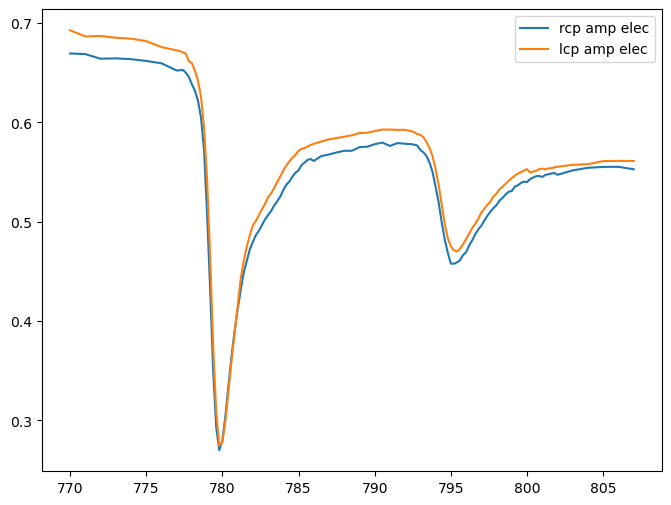

In [16]:
plt.close()
plt.plot(rcp_energy, rcp_elec_amp, label='rcp amp elec')
plt.plot(lcp_energy, lcp_elec_amp, label = 'lcp amp elec')
# plt.plot(rcp_energy, log_rcp_elec_amp, label='log rcp amp elec')
# plt.plot(lcp_energy, log_lcp_elec_amp, label='log lcp amp elec')
# plt.plot(rcp_energy, rcp_elec_phase, label='rcp elec phase')
# plt.plot(lcp_energy, lcp_elec_phase, label='lcp elec phase')
# plt.plot(rcp_energy, rcp_phase_gaussian_filter_elec, label='rcp gaussian filter phase')
# plt.plot(lcp_energy, lcp_phase_gaussian_filter_elec, label='lcp gaussian filter phase')
plt.legend()
plt.ioff()
plt.show()

#### Amplitude

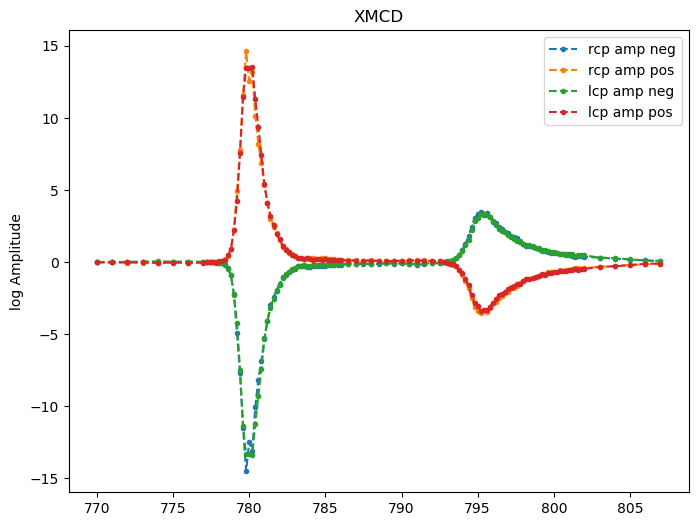

In [18]:
%matplotlib inline
plt.close()

plt.plot(rcp_energy, log_single_pol_rcp_xmcd_neg_amp*100,'.--',label='rcp amp neg')
plt.plot(rcp_energy, log_single_pol_rcp_xmcd_pos_amp*100,'.--',label='rcp amp pos')
plt.plot(rcp_energy, log_single_pol_lcp_xmcd_neg_amp*100,'.--',label='lcp amp neg')
plt.plot(rcp_energy, log_single_pol_lcp_xmcd_pos_amp*100,'.--',label='lcp amp pos')

plt.title('XMCD')
plt.ylabel('log Amplitude')
plt.legend()
plt.ioff()
plt.show()

#### Phase

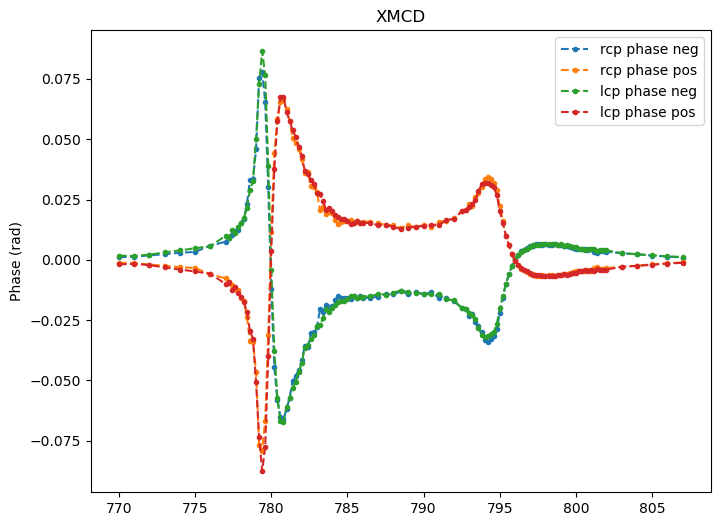

In [19]:
plt.close()
plt.plot(rcp_energy,single_pol_rcp_xmcd_neg_phase,'.--',label='rcp phase neg')
plt.plot(rcp_energy,single_pol_rcp_xmcd_pos_phase,'.--',label='rcp phase pos')
plt.plot(rcp_energy,single_pol_lcp_xmcd_neg_phase,'.--',label='lcp phase neg')
plt.plot(rcp_energy,single_pol_lcp_xmcd_pos_phase,'.--',label='lcp phase pos')

plt.title('XMCD')
plt.ylabel('Phase (rad)')
plt.legend()
plt.show()

#### Average Amplitude

In [20]:
amp_avg_spec = (single_pol_lcp_xmcd_pos_amp + single_pol_rcp_xmcd_pos_amp - single_pol_lcp_xmcd_neg_amp - single_pol_rcp_xmcd_neg_amp)/4
log_amp_avg_spec = (log_single_pol_lcp_xmcd_pos_amp + log_single_pol_rcp_xmcd_pos_amp - log_single_pol_lcp_xmcd_neg_amp - log_single_pol_rcp_xmcd_neg_amp)/4
mask_avg_std_amp = (mask_std_lcp_xmcd_neg_amp + mask_std_lcp_xmcd_pos_amp + mask_std_rcp_xmcd_neg_amp + mask_std_rcp_xmcd_pos_amp)/4
log_mask_avg_std_amp = (log_mask_std_lcp_xmcd_neg_amp + log_mask_std_lcp_xmcd_pos_amp + log_mask_std_rcp_xmcd_neg_amp + log_mask_std_rcp_xmcd_pos_amp)/4

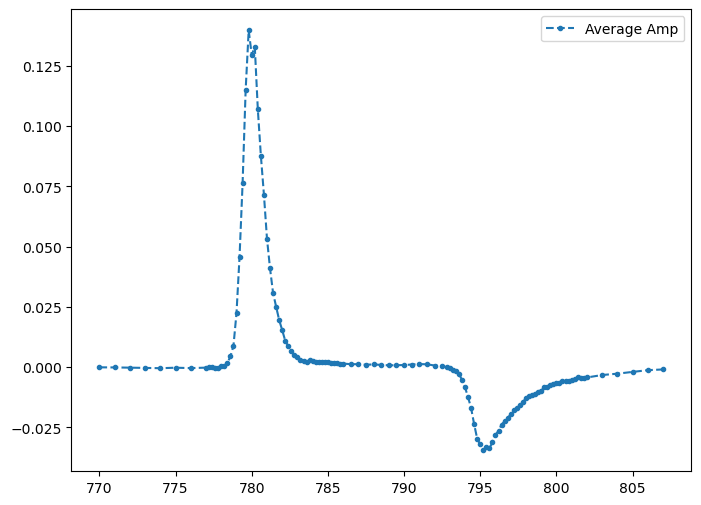

In [21]:
%matplotlib inline
plt.close()
plt.plot(rcp_energy, log_amp_avg_spec, '.--', label='Average Amp')
# plt.errorbar(rcp_energy, amp_avg_spec, mask_avg_std_amp, label='errorbar')
plt.legend()
plt.ioff()
plt.show()

#### Average Phase

In [22]:
phase_avg_spec = (single_pol_lcp_xmcd_pos_phase + single_pol_rcp_xmcd_pos_phase - single_pol_lcp_xmcd_neg_phase - single_pol_rcp_xmcd_neg_phase)/4
mask_avg_std_phase = (mask_std_lcp_xmcd_neg_phase + mask_std_lcp_xmcd_pos_phase + mask_std_rcp_xmcd_neg_phase + mask_std_rcp_xmcd_pos_phase)/4

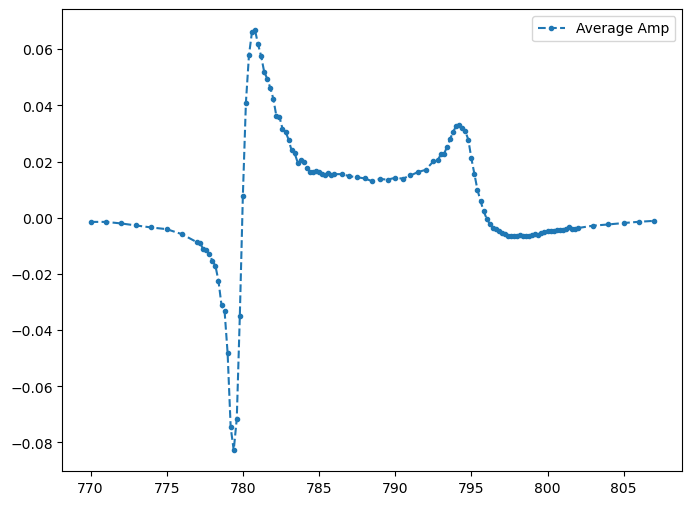

In [23]:
%matplotlib inline
plt.close()
plt.plot(rcp_energy, phase_avg_spec, '.--', label='Average Amp')
# plt.errorbar(rcp_energy, phase_avg_spec, mask_avg_std_amp, label='errorbar')
plt.legend()
plt.ioff()
plt.show()

#### Electronic + XMCD

##### segmentation mask

In [24]:
pos_elec_xmcd_rcp = segmentation(rcp_stack_aligned[23][60:261, 210:311].real)
neg_elec_xmcd_rcp = 1 - segmentation(rcp_stack_aligned[23][60:261, 210:311].real)
pos_elec_xmcd_lcp = 1 - segmentation(lcp_stack_aligned[23][60:261, 210:311].real)
neg_elec_xmcd_lcp = segmentation(lcp_stack_aligned[23][60:261, 210:311].real)

s1 = []
s2 = []
s3 = []
s4 = []
s5 = []
s6 = []
s7 = []
s8 = []


for i in range (0, len(rcp_energy)):
    b1 = rcp_stack_aligned.real[i][60:260, 210:310] * pos_elec_xmcd_rcp
    spec1 = np.mean(b1[b1!=0])
    s1.append(spec1)
    b2 = rcp_stack_aligned.real[i][60:260, 210:310] * neg_elec_xmcd_rcp
    spec2 = np.mean(b2[b2!=0])
    s2.append(spec2)
    b3 = lcp_stack_aligned.real[i][60:260, 210:310] * pos_elec_xmcd_lcp
    spec3 = np.mean(b3[b3!=0])
    s3.append(spec3)
    b4 = lcp_stack_aligned.real[i][60:260, 210:310] * neg_elec_xmcd_lcp
    spec4 = np.mean(b4[b4!=0])
    s4.append(spec4)
    b5 = rcp_phase_aligned.real[i][60:260, 210:310] * pos_elec_xmcd_rcp
    spec5 = np.mean(b5[b5!=0])
    s5.append(spec5)
    b6 = rcp_phase_aligned.real[i][60:260, 210:310] * neg_elec_xmcd_rcp
    spec6 = np.mean(b6[b6!=0])
    s6.append(spec6)
    b7 = lcp_phase_aligned.real[i][60:260, 210:310] * pos_elec_xmcd_lcp
    spec7 = np.mean(b7[b7!=0])
    s7.append(spec7)
    b8 = lcp_phase_aligned.real[i][60:260, 210:310] * neg_elec_xmcd_lcp
    spec8 = np.mean(b8[b8!=0])
    s8.append(spec8)
pos_amp_rcp_elec_xmcd_spectra = np.asarray(s1)
neg_amp_rcp_elec_xmcd_spectra = np.asarray(s2)
pos_amp_lcp_elec_xmcd_spectra = np.asarray(s3)
neg_amp_lcp_elec_xmcd_spectra = np.asarray(s4)
pos_phase_rcp_elec_xmcd_spectra = np.asarray(s5)
neg_phase_rcp_elec_xmcd_spectra = np.asarray(s6)
pos_phase_lcp_elec_xmcd_spectra = np.asarray(s7)
neg_phase_lcp_elec_xmcd_spectra = np.asarray(s8)

s1 = []
s2 = []
s3 = []
s4 = []
for i in range (0, len(rcp_energy)):
    b1 = log_rcp_stack_aligned.real[i][60:260, 210:310] * pos_elec_xmcd_rcp
    spec1 = np.mean(b1[b1!=0])
    s1.append(spec1)
    b2 = log_rcp_stack_aligned.real[i][60:260, 210:310] * neg_elec_xmcd_rcp
    spec2 = np.mean(b2[b2!=0])
    s2.append(spec2)
    b3 = log_lcp_stack_aligned.real[i][60:260, 210:310] * pos_elec_xmcd_lcp
    spec3 = np.mean(b3[b3!=0])
    s3.append(spec3)
    b4 = log_lcp_stack_aligned.real[i][60:260, 210:310] * neg_elec_xmcd_lcp
    spec4 = np.mean(b4[b4!=0])
    s4.append(spec4)
log_pos_amp_rcp_elec_xmcd_spectra = np.asarray(s1)
log_neg_amp_rcp_elec_xmcd_spectra = np.asarray(s2)
log_pos_amp_lcp_elec_xmcd_spectra = np.asarray(s3)
log_neg_amp_lcp_elec_xmcd_spectra = np.asarray(s4)  

### Absorption

In [25]:
rcp_absorption = rcp_elec_amp**2
lcp_absorption = lcp_elec_amp**2
log_rcp_absorption = np.exp(log_rcp_elec_amp)**2
log_lcp_absorption = np.exp(log_lcp_elec_amp)**2

### Errorbar by Splitting Image

#### Using segmentation mask

In [26]:
d1 = []
d2 = []
d3 = []
d4 = []
d5 = []
d6 = []
d7 = []
d8 = []


s1 = []
s2 = []
s3 = []
s4 = []
s5 = []
s6 = []
s7 = []
s8 = []

    
split_pos_rcp = np.split(pos_rcp, 4, axis=0)
split_neg_rcp = np.split(neg_rcp, 4, axis=0)
split_pos_lcp = np.split(pos_lcp, 4, axis=0)
split_neg_lcp = np.split(neg_lcp, 4, axis=0)

for i in range (0, len(rcp_energy)):
    split_img_1 = np.split(log_rcp_amp_xmcd[i,0:-1,0:-1], 4, axis=0)
    split_img_2 = np.split(log_lcp_amp_xmcd[i,0:-1,0:-1], 4, axis=0) 
    split_img_3 = np.split(rcp_phase_xmcd[i,0:-1,0:-1], 4, axis=0)
    split_img_4 = np.split(lcp_phase_xmcd[i,0:-1,0:-1], 4, axis=0)
    for j in range (0,4):
        b1 = split_img_1[j] * split_pos_rcp[j]
        spec1 = np.mean(b1[b1!=0])
        s1.append(spec1)
        b2 = split_img_1[j] * split_neg_rcp[j]
        spec2 = np.mean(b2[b2!=0])
        s2.append(spec2)
        b3 = split_img_2[j] * split_pos_lcp[j]
        spec3 = np.mean(b3[b3!=0])
        s3.append(spec3)
        b4 = split_img_2[j] * split_neg_lcp[j]
        spec4 = np.mean(b4[b4!=0])
        s4.append(spec4)
        b5 = split_img_3[j] * split_pos_rcp[j]
        spec5 = np.mean(b5[b5!=0])
        s5.append(spec5)
        b6 = split_img_3[j] * split_neg_rcp[j]
        spec6 = np.mean(b6[b6!=0])
        s6.append(spec6)
        b7 = split_img_4[j] * split_pos_lcp[j]
        spec7 = np.mean(b7[b7!=0])
        s7.append(spec7)
        b8 = split_img_4[j] * split_neg_lcp[j]
        spec8 = np.mean(b8[b8!=0])
        s8.append(spec8)
        
    tmp1 = np.asarray(s1)
    tmp2 = np.asarray(s2)
    tmp3 = np.asarray(s3)
    tmp4 = np.asarray(s4)
    tmp5 = np.asarray(s5)
    tmp6 = np.asarray(s6)
    tmp7 = np.asarray(s7)
    tmp8 = np.asarray(s8)
    
four_spectra_rcp_amp_pos = tmp1.reshape(118,4)
four_spectra_rcp_amp_neg = tmp2.reshape(118,4)
four_spectra_lcp_amp_pos = tmp3.reshape(118,4)
four_spectra_lcp_amp_neg = tmp4.reshape(118,4)
four_spectra_rcp_phase_pos = tmp5.reshape(118,4)
four_spectra_rcp_phase_neg = tmp6.reshape(118,4)
four_spectra_lcp_phase_pos = tmp7.reshape(118,4)
four_spectra_lcp_phase_neg = tmp8.reshape(118,4)


split_spectra_log_rcp_amp_pos = np.asarray(np.split(four_spectra_rcp_amp_pos, 4, axis=1))
split_spectra_log_rcp_amp_neg = np.asarray(np.split(four_spectra_rcp_amp_neg, 4, axis=1))
split_spectra_log_lcp_amp_pos = np.asarray(np.split(four_spectra_lcp_amp_pos, 4, axis=1))
split_spectra_log_lcp_amp_neg = np.asarray(np.split(four_spectra_lcp_amp_neg, 4, axis=1))
split_spectra_rcp_phase_pos = np.asarray(np.split(four_spectra_rcp_phase_pos, 4, axis=1))
split_spectra_rcp_phase_neg = np.asarray(np.split(four_spectra_rcp_phase_neg, 4, axis=1))
split_spectra_lcp_phase_pos = np.asarray(np.split(four_spectra_lcp_phase_pos, 4, axis=1))
split_spectra_lcp_phase_neg = np.asarray(np.split(four_spectra_lcp_phase_neg, 4, axis=1))

mean_split_spectra_log_rcp_amp_pos = np.mean(split_spectra_log_rcp_amp_pos, axis=0)
mean_split_spectra_log_rcp_amp_neg = np.mean(split_spectra_log_rcp_amp_neg, axis=0)
mean_split_spectra_log_lcp_amp_pos = np.mean(split_spectra_log_lcp_amp_pos, axis=0)
mean_split_spectra_log_lcp_amp_neg = np.mean(split_spectra_log_lcp_amp_neg, axis=0)
mean_split_spectra_rcp_phase_pos = np.mean(split_spectra_rcp_phase_pos, axis=0)
mean_split_spectra_rcp_pahse_neg = np.mean(split_spectra_rcp_phase_neg, axis=0)
mean_split_spectra_lcp_phase_pos = np.mean(split_spectra_lcp_phase_pos, axis=0)
mean_split_spectra_lcp_phase_neg = np.mean(split_spectra_lcp_phase_neg, axis=0)

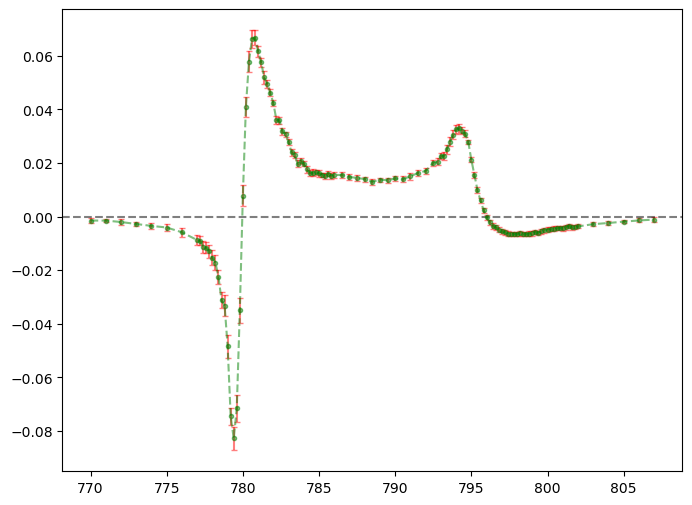

In [29]:
phase_err1 = np.std(split_spectra_rcp_phase_pos, axis=0)
phase_err2 = np.std(split_spectra_rcp_phase_neg, axis=0)
phase_err3 = np.std(split_spectra_lcp_phase_pos, axis=0)
phase_err4 = np.std(split_spectra_lcp_phase_neg, axis=0)

amp_err1 = np.std(split_spectra_log_rcp_amp_pos, axis=0)
amp_err2 = np.std(split_spectra_log_rcp_amp_neg, axis=0)
amp_err3 = np.std(split_spectra_log_lcp_amp_pos, axis=0)
amp_err4 = np.std(split_spectra_log_lcp_amp_neg, axis=0)

split_amp_error = np.asarray([amp_err1, amp_err2, amp_err3, amp_err4])
split_phase_error = np.asarray([phase_err1, phase_err2, phase_err3, phase_err4])
split_avg_amp_error = np.mean(split_amp_error, axis=0)
split_avg_phase_error = np.mean(split_phase_error,axis=0)
plt.errorbar(rcp_energy, phase_avg_spec, yerr=split_avg_phase_error[:,0], color='g', marker='.', linestyle='--', capsize=2, ecolor='r', label='Phase', alpha=0.5)
# plt.errorbar(rcp_energy, log_amp_avg_spec, yerr=split_avg_amp_error[:,0], color='b', marker='.', linestyle='--', capsize=2, ecolor='r', label='Amplitude', alpha=0.5)
plt.axhline(0,ls='--',color='k',alpha=0.5)
plt.show()

## Noise Analysis of all images

### Caluclate high frequency noise with FFT

In [30]:
def ring_ellipse_mask(img, inner_radius=2, outer_radius=4, semi_major_axis=6, semi_minor_axis=30):
    wx,wy = img.shape
    xx,yy = np.meshgrid(np.arange(wy)-wy//2, np.arange(wx)-wx//2)
    rr = np.sqrt(xx**2/semi_major_axis + yy**2/semi_minor_axis)
    mask1 = rr>outer_radius
    mask2 = rr<inner_radius
    mask = mask1 + mask2
    return mask

### Apply with entire stack

In [31]:
ring_elliptical_mask = np.fft.ifftshift(ring_ellipse_mask(log_rcp_amp_xmcd[23],inner_radius=0, outer_radius=7, semi_major_axis=6, semi_minor_axis=30))

d1 = []
d2 = []
for i in range (0, len(rcp_energy)): 
    amp_img = log_rcp_amp_xmcd[i] * 100
    phase_img = rcp_phase_xmcd[i] * 100
    fft_amp_img = np.fft.fftn(amp_img)
    fft_phase_img = np.fft.fftn(phase_img)
    masked_fft_amp_img = fft_amp_img * ring_elliptical_mask
    masked_fft_phase_img = fft_phase_img * ring_elliptical_mask
    noise_amp_img  = np.std(((np.fft.ifftn(masked_fft_amp_img).real[10:-11,10:-11])))
    noise_phase_img = np.std(np.fft.ifftn(masked_fft_phase_img).real[10:-11, 10:-11])
    d1.append(noise_amp_img)
    d2.append(noise_phase_img)
high_freq_noise_log_amp_xmcd = np.asarray(d1)
high_freq_noise_phase_xmcd = np.asarray(d2)

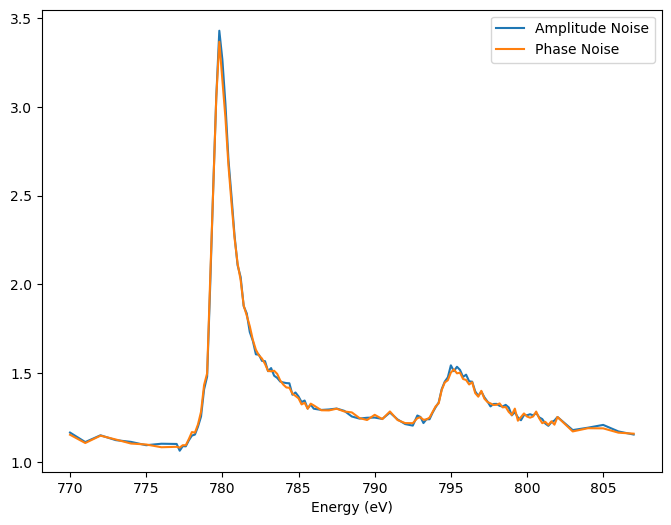

In [32]:
%matplotlib inline
plt.close()
plt.plot(rcp_energy, high_freq_noise_log_amp_xmcd, label='Amplitude Noise')
plt.plot(rcp_energy, high_freq_noise_phase_xmcd, label='Phase Noise')
plt.xlabel('Energy (eV)')
# plt.ylabel()
plt.legend()
plt.show()

### Relation Between Transmission and Noise 

In [42]:
def noise_fit(absorption, scaling, offset):
    return scaling/(absorption) + offset


In [43]:
tmp_x = rcp_absorption
tmp_y = noise_100nm_amp
sorted_x, sorted_y = zip(*sorted(zip(tmp_x, tmp_y)))
pcov, pvar = curve_fit(noise_fit, xdata=sorted_x, ydata=sorted_y)

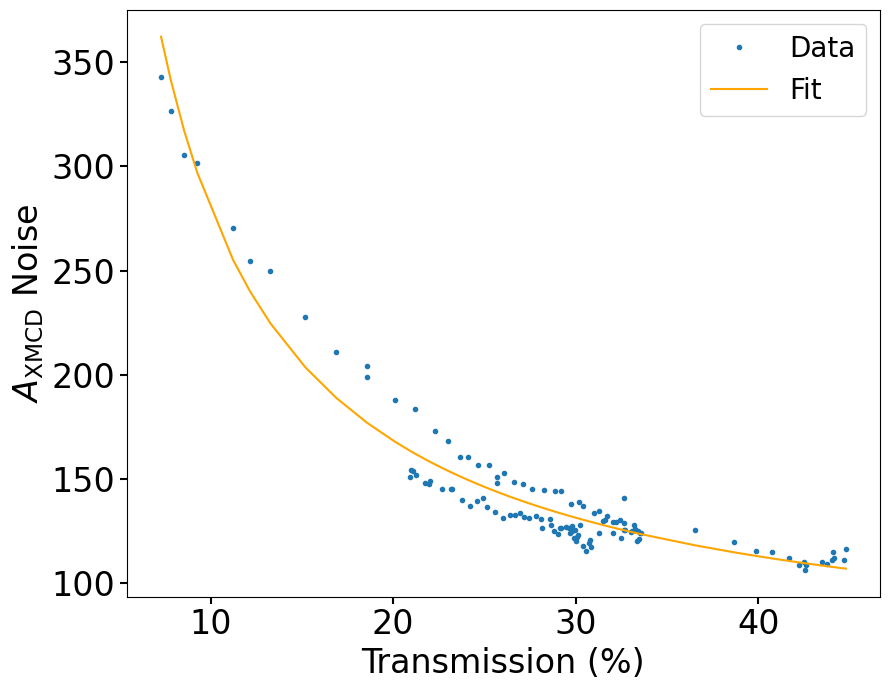

In [44]:

%matplotlib inline
plt.close()
fig, ax = plt.subplots(figsize=(9,7))
fig.subplots_adjust(right=1)

ax.set_xlabel("Transmission (%)",fontsize=24)
ax.set_ylabel("$A_\mathrm{XMCD}$ Noise",fontsize=24)

ax.plot(np.asarray(sorted_x)*100, np.asarray(sorted_y)*100 , color='tab:blue',label='Data', marker='.', ls='')
ax.plot(np.asarray(sorted_x)*100, noise_fit(np.asarray(sorted_x), *pcov)*100, color='orange',label='Fit')


plt.legend(fontsize=20, loc='upper right')

tkw = dict(size=5, width=1.5, labelsize=24)
ax.tick_params(axis='y', **tkw)

ax.tick_params(axis='x', **tkw)

plt.tight_layout()
plt.show()




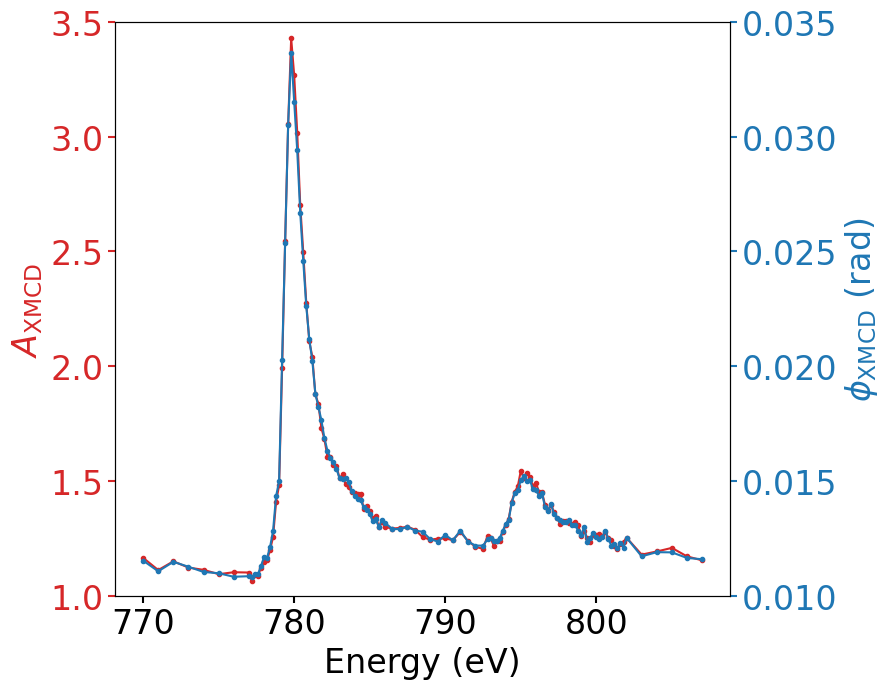

In [84]:
plt.close()
fig, ax = plt.subplots(figsize=(9,7))
fig.subplots_adjust(right=1)
twin1 = ax.twinx()
ax.set_xlabel("Energy (eV)",fontsize=24)
ax.set_ylabel("$A_\mathrm{XMCD}$",fontsize=24)
twin1.set_ylabel("$\phi_\mathrm{XMCD}$ (rad)",fontsize=24)
p1, = ax.plot(rcp_energy, noise_100nm_amp*100 , color='tab:red', marker='.', ls='-', label='$\mathrm{A_{XMCD}}$')
p2, = twin1.plot(rcp_energy, noise_100nm_phase , color='tab:blue', marker='.', ls='-',label='$\mathrm{\phi_{XMCD}}$')
ax.set_ylim(1,3.5)
twin1.set_ylim(0.01,0.035)
ax.yaxis.get_label().set_color(p1.get_color())
twin1.yaxis.get_label().set_color(p2.get_color())
tkw = dict(size=5, width=1.5, labelsize=24)
ax.tick_params(axis='y',colors=p1.get_color(), **tkw)
twin1.tick_params(axis='y',colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)
twin1.tick_params(axis='x', **tkw)

plt.tight_layout()
plt.show()




## SNR

In [125]:
amp_400nm = np.loadtxt(r'FeGd_analysed_arrays/400nm_amp_avg.csv')
amp_1000nm = np.loadtxt(r'FeGd_analysed_arrays/1000nm_amp_avg.csv')
amp_1700nm = np.loadtxt(r'FeGd_analysed_arrays/1700nm_amp_avg.csv')
amp_100nm = -log_amp_avg_spec

phase_400nm = np.loadtxt(r'FeGd_analysed_arrays/400nm_phase_avg.csv')
phase_1000nm = np.loadtxt(r'FeGd_analysed_arrays/1000nm_phase_avg.csv')
phase_1700nm = np.loadtxt(r'FeGd_analysed_arrays/1700nm_phase_avg.csv')
phase_100nm = -phase_avg_spec

rcp_file = h5py.File(r'FeGd_spectroptycho_data/FeGd_400nm_complex.nxs', 'r')
energy_400nm = np.array(rcp_file['entry1/Counter1/photon_energy'])
rcp_file = h5py.File(r'FeGd_spectroptycho_data/FeGd_1000nm_complex.nxs', 'r')
energy_1000nm = np.array(rcp_file['entry1/Counter1/photon_energy'])
rcp_file = h5py.File(r'FeGd_spectroptycho_data/FeGd_1700nm_complex.nxs', 'r')
energy_1700nm = np.array(rcp_file['entry1/Counter1/photon_energy'])
rcp_file = h5py.File(r'CoPt_spectroptycho_data/CoPt_RCP_spectroptycho_complex.nxs', 'r')  # 1000 DM long range
rcp_energy = np.array(rcp_file['entry1/Counter1/photon_energy'])

transmission_400nm = np.loadtxt(r'FeGd_analysed_arrays/400nm_transmission_spec.csv')
transmission_1000nm = np.loadtxt(r'FeGd_analysed_arrays/1000nm_transmission_spec.csv')
transmission_1700nm = np.loadtxt(r'FeGd_analysed_arrays/1700nm_transmission_spec.csv')

noise_100nm_amp = high_freq_noise_log_amp_xmcd
noise_100nm_phase = high_freq_noise_phase_xmcd
noise_400nm_amp = np.loadtxt(r'FeGd_analysed_arrays/400nm_amp_noise.csv')
noise_400nm_phase = np.loadtxt(r'FeGd_analysed_arrays/400nm_phase_noise.csv')
noise_1000nm_amp = np.loadtxt(r'FeGd_analysed_arrays/1000nm_amp_noise.csv')
noise_1000nm_phase = np.loadtxt(r'FeGd_analysed_arrays/1000nm_phase_noise.csv')
noise_1700nm_amp = np.loadtxt(r'FeGd_analysed_arrays/1700nm_amp_noise.csv')
noise_1700nm_phase = np.loadtxt(r'FeGd_analysed_arrays/1700nm_phase_noise.csv')


std_amp_400nm = np.loadtxt(r'FeGd_analysed_arrays/400nm_log_amp_avg_std.csv')
std_amp_1000nm = np.loadtxt(r'FeGd_analysed_arrays/1000nm_amp_avg_std.csv')
std_amp_100nm = np.loadtxt(r'FeGd_analysed_arrays/100nm_amp_avg_std.csv')
std_amp_1700nm = np.loadtxt(r'FeGd_analysed_arrays/1700nm_amp_avg_std.csv')

std_phase_400nm = np.loadtxt(r'FeGd_analysed_arrays/400nm_phase_avg_std.csv')
std_phase_1000nm = np.loadtxt(r'FeGd_analysed_arrays/1000nm_phase_avg_std.csv')
std_phase_100nm = np.loadtxt(r'FeGd_analysed_arrays/100nm_phase_avg_std.csv')
std_phase_1700nm = np.loadtxt(r'FeGd_analysed_arrays/1700nm_phase_avg_std.csv')

snr_100nm_amp = amp_100nm / std_amp_100nm
snr_400nm_amp = np.nan_to_num(amp_400nm / std_amp_400nm)
snr_1000nm_amp = np.nan_to_num(amp_1000nm / std_amp_1000nm)
snr_1700nm_amp = np.nan_to_num(amp_1700nm / std_amp_1700nm)

snr_100nm_phase = phase_100nm / std_phase_100nm
snr_400nm_phase = np.nan_to_num(phase_400nm / std_phase_400nm)
snr_1000nm_phase = np.nan_to_num(phase_1000nm / std_phase_1000nm)
snr_1700nm_phase = np.nan_to_num(phase_1700nm / std_phase_1700nm)

avg_100nm_amp = np.mean(np.abs(snr_100nm_amp))
avg_100nm_phase = np.mean(np.abs(snr_100nm_phase))

avg_400nm_amp = np.mean(np.abs(np.nan_to_num(snr_400nm_amp)))
avg_400nm_phase = np.mean(np.abs(np.nan_to_num(snr_400nm_phase)))

avg_1000nm_amp = np.mean(np.abs(np.nan_to_num(snr_1000nm_amp)))
avg_1000nm_phase = np.mean(np.abs(np.nan_to_num(snr_1000nm_phase)))

avg_1700nm_amp = np.mean(np.abs(np.nan_to_num(snr_1700nm_amp)))
avg_1700nm_phase = np.mean(np.abs(np.nan_to_num(snr_1700nm_phase)))

max_100nm_amp = np.max(np.abs(snr_100nm_amp))
energy_max_100nm_amp = rcp_energy[np.argmax(np.abs(snr_100nm_amp))]
index_energy_max_100nm_amp = np.argmax(np.abs(snr_100nm_amp))
max_100nm_phase = np.max(np.abs(snr_100nm_phase))
energy_max_100nm_phase = rcp_energy[np.argmax(np.abs(snr_100nm_phase))]
index_energy_max_100nm_phase = np.argmax(np.abs(snr_100nm_phase))

max_400nm_amp = np.max(np.abs(np.nan_to_num(snr_400nm_amp)))
energy_max_400nm_amp = energy_400nm[np.argmax((np.abs(np.nan_to_num(snr_400nm_amp))))]
index_energy_max_400nm_amp = np.argmax(np.abs(np.nan_to_num(snr_400nm_amp)))
max_400nm_phase = np.max(np.abs(np.nan_to_num(snr_400nm_phase)))
energy_max_400nm_phase = energy_400nm[np.argmax(np.abs(snr_400nm_phase))]
index_energy_max_400nm_phase = np.argmax(np.abs(snr_400nm_phase))

max_1000nm_amp = np.max(np.abs(np.nan_to_num(snr_1000nm_amp)))
energy_max_1000nm_amp = energy_1000nm[np.argmax(np.abs(np.nan_to_num(snr_1000nm_amp)))]
index_energy_max_1000nm_amp = np.argmax(np.abs(np.nan_to_num(snr_1000nm_amp)))
max_1000nm_phase = np.max(np.abs(np.nan_to_num(snr_1000nm_phase)))
energy_max_1000nm_phase = energy_1000nm[np.argmax(np.abs(np.nan_to_num(snr_1000nm_phase)))]
index_energy_max_1000nm_phase = np.argmax(np.abs(np.nan_to_num(snr_1000nm_phase)))

max_1700nm_amp = np.max(np.abs(np.nan_to_num(snr_1700nm_amp)))
index_energy_max_1700nm_amp = np.argmax(np.abs(snr_1700nm_amp))
max_1700nm_phase = np.max(np.abs(np.nan_to_num(snr_1700nm_phase)))
index_energy_max_1700nm_phase = np.argmax(np.abs(snr_1700nm_phase))
                                    
SNR_amp_all = np.asarray([avg_100nm_amp, avg_400nm_amp, avg_1000nm_amp, avg_1700nm_amp])
SNR_phase_all = np.asarray([avg_100nm_phase, avg_400nm_phase, avg_1000nm_phase, avg_1700nm_phase])
SNR_amp_max = np.asarray([max_100nm_amp, max_400nm_amp, max_1000nm_amp, max_1700nm_amp])
SNR_phase_max = np.asarray([max_100nm_phase, max_400nm_phase, max_1000nm_phase, max_1700nm_phase])

### Simulation

#### Transmission function simulation

In [126]:
interp_energy = np.arange(770, 808, 0.005)
interp_pos_rcp_elec_amp = np.interp(interp_energy, rcp_energy, rcp_elec_amp)
interp_neg_lcp_elec_amp = np.interp(interp_energy, rcp_energy, lcp_elec_amp)
interp_avg_elec_spec = (interp_pos_rcp_elec_amp**2 + interp_neg_lcp_elec_amp**2)/2
interp_mu_avg_elec_spec = -(np.log(interp_avg_elec_spec)/(100*1e-9))
starting_thickness = 0
ending_thickness = 4000
step_size=10
thickness_simulated = np.arange(starting_thickness, ending_thickness,step_size)


def sim_elec_spec(n):
    return np.exp(-interp_mu_avg_elec_spec * n * 1e-9)

pcov, pvar = curve_fit(noise_fit, xdata=np.nan_to_num(transmission_1000nm/transmission_1000nm[0]), ydata=np.nan_to_num(noise_1000nm_amp))
interp_sim_avg_elec_spec = (np.asarray([sim_elec_spec(i) for i in thickness_simulated]))
interp_sim_noise_amp = noise_fit(interp_sim_avg_elec_spec, *pcov)

#### Amplitude Simulation

In [127]:
scaling_factor = 1 
amp_sigma_1d_filter = 1
pos_rcp_abs_elec_xmcd = gaussian_filter(scaling_factor * pos_amp_rcp_elec_xmcd_spectra**2,amp_sigma_1d_filter)
neg_rcp_abs_elec_xmcd = gaussian_filter(scaling_factor * neg_amp_rcp_elec_xmcd_spectra**2,amp_sigma_1d_filter)
pos_lcp_abs_elec_xmcd = gaussian_filter(scaling_factor * pos_amp_lcp_elec_xmcd_spectra**2,amp_sigma_1d_filter)
neg_lcp_abs_elec_xmcd = gaussian_filter(scaling_factor * neg_amp_lcp_elec_xmcd_spectra**2,amp_sigma_1d_filter)


interp_energy = np.arange(770,808,0.005)
interp_pos_rcp_abs_elec_xmcd = np.interp(interp_energy, rcp_energy, pos_rcp_abs_elec_xmcd)
interp_neg_rcp_abs_elec_xmcd = np.interp(interp_energy, rcp_energy, neg_rcp_abs_elec_xmcd)
interp_pos_lcp_abs_elec_xmcd = np.interp(interp_energy, rcp_energy, pos_lcp_abs_elec_xmcd)
interp_neg_lcp_abs_elec_xmcd = np.interp(interp_energy, rcp_energy, neg_lcp_abs_elec_xmcd)

interp_mu_pos_rcp_100nm = -(np.log(interp_pos_rcp_abs_elec_xmcd)/(100*1e-9))
interp_mu_neg_rcp_100nm = -(np.log(interp_neg_rcp_abs_elec_xmcd)/(100*1e-9))
interp_mu_pos_lcp_100nm = -(np.log(interp_pos_lcp_abs_elec_xmcd)/(100*1e-9))
interp_mu_neg_lcp_100nm = -(np.log(interp_neg_lcp_abs_elec_xmcd)/(100*1e-9))

def detection_limit_amp(data1, data2):
    """ For two polarisation
    limit: sets what the detector can detect. For example if detector can detect 0.5% transmission set limit to 0.005"""
    tmp1 = data1
    tmp2 = data2
    limit = 0.000005
    for i in range (0, len(tmp1)):
        for j in range (0, len(tmp1[i])):
            if tmp1[i,j] < np.log(limit) and tmp2[i,j] < np.log(limit):
                tmp1[i,j] = 0
                tmp2[i,j] = 0
    return tmp1, tmp2



def interp_sim_abs(n, pol='rcp', domain = 'pos' ):
    if pol == 'rcp' and domain == 'pos':
        return (-interp_mu_pos_rcp_100nm * n * 1e-9)
    elif pol == 'rcp' and domain == 'neg':
        return (-interp_mu_neg_rcp_100nm * n * 1e-9)
    elif pol == 'lcp' and domain == 'pos':
        return (-interp_mu_pos_lcp_100nm * n * 1e-9)
    elif pol == 'lcp' and domain == 'neg':
        return (-interp_mu_neg_lcp_100nm * n * 1e-9)
    else:
        raise Exception('pol can only be \'lcp\' or \'rcp\' and domain can only be \'pos\' or \'neg\'. Default is rcp and pos')

        
thickness_simulated = np.arange(starting_thickness, ending_thickness,step_size)
interp_sim_amp_rcp_pos = np.asarray([interp_sim_abs(i, pol='rcp', domain='pos') for i in np.arange(starting_thickness, ending_thickness, step_size)])
interp_sim_amp_rcp_neg = np.asarray([interp_sim_abs(i, pol='rcp', domain='neg') for i in np.arange(starting_thickness, ending_thickness, step_size)])
interp_sim_amp_lcp_pos= np.asarray([interp_sim_abs(i, pol='lcp', domain='pos') for i in np.arange(starting_thickness, ending_thickness, step_size)])
interp_sim_amp_lcp_neg = np.asarray([interp_sim_abs(i, pol='lcp', domain='neg') for i in np.arange(starting_thickness, ending_thickness, step_size)])

# Imposing detection limit

interp_sim_amp_rcp_pos, interp_sim_amp_rcp_neg = detection_limit_amp(interp_sim_amp_rcp_pos, interp_sim_amp_rcp_neg)
interp_sim_amp_lcp_pos, interp_sim_amp_lcp_neg = detection_limit_amp(interp_sim_amp_lcp_pos, interp_sim_amp_lcp_neg)

interp_sim_amp_xmcd_rcp = (((interp_sim_amp_rcp_pos) - (interp_sim_amp_rcp_neg))/4)
interp_sim_amp_xmcd = (((interp_sim_amp_rcp_pos) - (interp_sim_amp_lcp_neg))/4)
interp_sim_snr_xmcd_rcp = np.nan_to_num(interp_sim_amp_xmcd_rcp/interp_sim_noise_amp)*1.09

In [128]:
d1 = []
d2 = []
d3 = []
for i in range(0, len(interp_sim_amp_xmcd)):
    t1 = np.max(np.abs(interp_sim_snr_xmcd_rcp[i]))
    d1.append(t1)
    t2 = np.argmax(np.abs(interp_sim_snr_xmcd_rcp[i]))
    d2.append(t2)
    d3.append(interp_energy[t2])
interp_max_sim_amp_xmcd_rcp = np.asarray(d1)
interp_index_max_sim_amp_xmcd_rcp = np.asarray(d2)
interp_energy_max_sim_amp_xmcd_rcp = np.asarray(d3)

#### Phase Simulation

In [129]:
interp_wavelength = h*c*1e9/(interp_energy*e)
interp_k = 2*pi/interp_wavelength

scaling_factor= 1

phase_sigma_1d_filter = 1

filtered_pos_phase_rcp_elec_xmcd_spectra = gaussian_filter(scaling_factor * np.delete(pos_phase_rcp_elec_xmcd_spectra, 8 ), phase_sigma_1d_filter)
filtered_neg_phase_rcp_elec_xmcd_spectra = gaussian_filter(scaling_factor * np.delete(neg_phase_rcp_elec_xmcd_spectra,8), phase_sigma_1d_filter)
filtered_pos_phase_lcp_elec_xmcd_spectra = gaussian_filter(scaling_factor * np.delete(pos_phase_lcp_elec_xmcd_spectra,8), phase_sigma_1d_filter)
filtered_neg_phase_lcp_elec_xmcd_spectra = gaussian_filter(scaling_factor * np.delete(neg_phase_lcp_elec_xmcd_spectra,8), phase_sigma_1d_filter)

interp_pos_phase_rcp_elec_xmcd_spectra = np.interp(interp_energy, np.delete(rcp_energy,8), filtered_pos_phase_rcp_elec_xmcd_spectra)
interp_neg_phase_rcp_elec_xmcd_spectra = np.interp(interp_energy, np.delete(rcp_energy,8), filtered_neg_phase_rcp_elec_xmcd_spectra)
interp_pos_phase_lcp_elec_xmcd_spectra = np.interp(interp_energy, np.delete(rcp_energy,8), filtered_pos_phase_lcp_elec_xmcd_spectra)
interp_neg_phase_lcp_elec_xmcd_spectra = np.interp(interp_energy, np.delete(rcp_energy,8), filtered_neg_phase_lcp_elec_xmcd_spectra)


interp_delta_pos_rcp = interp_pos_phase_rcp_elec_xmcd_spectra * interp_wavelength / (2 * pi * 100 * 1e-9)
interp_delta_neg_rcp = interp_neg_phase_rcp_elec_xmcd_spectra * interp_wavelength / (2 * pi * 100 * 1e-9)
interp_delta_pos_lcp = interp_pos_phase_lcp_elec_xmcd_spectra * interp_wavelength / (2 * pi * 100 * 1e-9)
interp_delta_neg_lcp = interp_neg_phase_lcp_elec_xmcd_spectra * interp_wavelength / (2 * pi * 100 * 1e-9)

def interp_sim_phi_elec_xmcd(n, pol='rcp', domain='pos'):
    if pol == 'rcp' and domain== 'pos':
        return interp_delta_pos_rcp * interp_k * n * 1e-9
    elif pol == 'rcp' and domain == 'neg':
        return interp_delta_neg_rcp * interp_k * n * 1e-9
    elif pol == 'lcp' and domain == 'pos':
        return interp_delta_pos_lcp * interp_k * n * 1e-9
    elif pol == 'lcp' and domain == 'neg':
        return interp_delta_neg_lcp * interp_k * n * 1e-9
    else:
        raise Exception('pol can only be \'lcp\' or \'rcp\' and domain can only be \'pos\' or \'neg\'. Default is rcp and pos')
        
        
interp_sim_phase_rcp_pos = np.asarray([interp_sim_phi_elec_xmcd(i, pol='rcp', domain='pos') for i in np.arange(starting_thickness, ending_thickness, step_size)])
interp_sim_phase_rcp_neg = np.asarray([interp_sim_phi_elec_xmcd(i, pol='rcp', domain='neg') for i in np.arange(starting_thickness, ending_thickness, step_size)])
interp_sim_phase_lcp_pos = np.asarray([interp_sim_phi_elec_xmcd(i, pol='lcp', domain='pos') for i in np.arange(starting_thickness, ending_thickness, step_size)])
interp_sim_phase_lcp_neg = np.asarray([interp_sim_phi_elec_xmcd(i, pol='lcp', domain='neg') for i in np.arange(starting_thickness, ending_thickness, step_size)])
interp_sim_phase_rcp_xmcd = (interp_sim_phase_rcp_pos - interp_sim_phase_rcp_neg)/2 *1.143
interp_sim_phase_lcp_xmcd = (interp_sim_phase_lcp_pos - interp_sim_phase_lcp_neg)/2

interp_sim_phase_xmcd = (interp_sim_phase_rcp_pos - interp_sim_phase_lcp_neg)/2


In [130]:
mask_phase_from_transmission = np.abs(interp_sim_amp_rcp_pos) > 0
interp_transmission_sim_phase_xmcd = interp_sim_phase_rcp_xmcd * mask_phase_from_transmission
interp_sim_noise_phase_xmcd = np.nan_to_num(interp_transmission_sim_phase_xmcd / interp_sim_noise_amp)

d1 = []
d2 = []
d3 = []
for i in range(0,len(interp_transmission_sim_phase_xmcd)):

    t1 = np.max(np.abs(interp_sim_noise_phase_xmcd[i]))
    d1.append(t1)

    t2 = np.argmax(np.abs(interp_sim_noise_phase_xmcd[i]))
    d2.append(t2)
    d3.append(interp_energy[t2])
interp_max_sim_phase_xmcd_rcp = np.asarray(d1)
interp_index_max_sim_phase_xmcd_rcp = np.asarray(d2)
interp_energy_max_sim_phase_xmcd_rcp = np.asarray(d3)

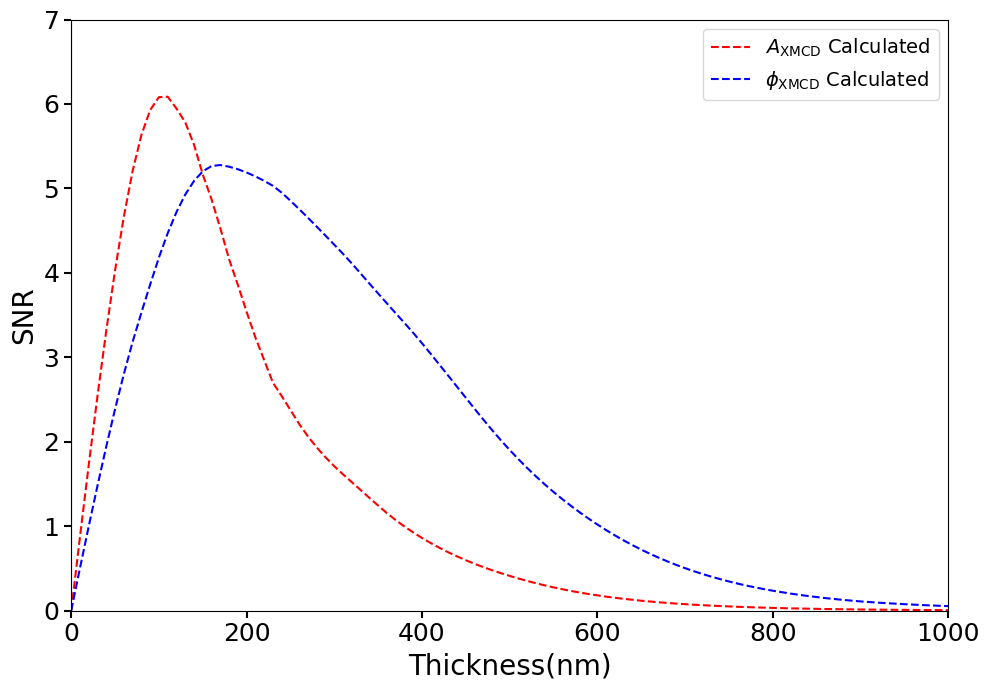

In [131]:

%matplotlib inline
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,7))

thickness_multiplier = 1
signal_multiplier_amp = 1
signal_multiplier_phase = 1

p1, = ax.plot(thickness_multiplier*thickness_simulated, interp_max_sim_amp_xmcd_rcp*signal_multiplier_amp, color='red',ls='--', marker='', label='$A_\mathrm{XMCD}$ Calculated') #previous value was 0.42
p2, = ax.plot(thickness_multiplier*thickness_simulated, interp_max_sim_phase_xmcd_rcp*signal_multiplier_phase, color='blue', ls='--', marker='', label='$\phi_\mathrm{XMCD}$ Calculated') #previous value was 0.42

ax.axvline()
tkw = dict(size=5, width=1.5, labelsize=18)
ax.tick_params(axis='y', **tkw)
ax.tick_params(axis='x', **tkw)

ax.set_xlim(0,1000)
ax.set_ylim(0,7)

ax.set_xlabel('Thickness(nm)',fontsize=20)
ax.set_ylabel('SNR',fontsize=20)


ax.legend(handles=[p1,p2], fontsize=14)
plt.tight_layout()

plt.show()

In [132]:
thickness_meas = np.asarray([100,400, 1000, 1700])
mix_SNR_measured_amp = np.asarray([max_snr_amp[0], max_snr_amp[1], SNR_amp_max[2], SNR_amp_max[3]])
mix_SNR_measured_phase = np.asarray([max_snr_phase[0], max_snr_phase[1], SNR_phase_max[2], SNR_phase_max[3]])
mix_thickness = [217, 400, 1000, 1700]

#### Errorbar SNR 

In [134]:
err_400nm_amp = np.loadtxt(r'FeGd_analysed_arrays/400nm_amp_avg_err.csv')
err_400nm_phase = np.loadtxt(r'FeGd_analysed_arrays/400nm_phase_avg_err.csv')

err_1000nm_amp = np.loadtxt(r'FeGd_analysed_arrays/1000nm_amp_avg_err.csv')
err_1000nm_phase = np.loadtxt(r'FeGd_analysed_arrays/1000nm_phase_avg_err.csv')

err_1700nm_amp = np.loadtxt(r'FeGd_analysed_arrays/1700nm_amp_avg_err.csv')
err_1700nm_phase = np.loadtxt(r'FeGd_analysed_arrays/1700nm_phase_avg_err.csv')

In [135]:
err_snr_100nm_amp = split_avg_amp_error[:,0]/noise_100nm_amp 
err_snr_100nm_phase = split_avg_phase_error[:,0]/noise_100nm_phase 

err_snr_400nm_amp = err_400nm_amp/noise_400nm_amp
err_snr_400nm_phase = err_400nm_phase/noise_400nm_phase

err_snr_1000nm_amp = err_1000nm_amp/noise_1000nm_amp
err_snr_1000nm_phase = err_1000nm_phase/noise_1000nm_phase

err_snr_1700nm_amp = err_1700nm_amp/noise_1700nm_amp
err_snr_1700nm_phase = err_1700nm_phase/noise_1700nm_phase



In [136]:
mix_snr_err_amp = [err_snr_100nm_amp[index_energy_max_100nm_amp], err_snr_400nm_amp[index_energy_max_400nm_amp], err_snr_1000nm_amp[index_energy_max_1000nm_amp], err_snr_1700nm_amp[index_energy_max_1700nm_amp]]
mix_snr_err_phase = [err_snr_100nm_phase[index_energy_max_100nm_phase], err_snr_400nm_phase[index_energy_max_400nm_phase], err_snr_1000nm_phase[index_energy_max_1000nm_phase], err_snr_1700nm_phase[index_energy_max_1700nm_phase]]

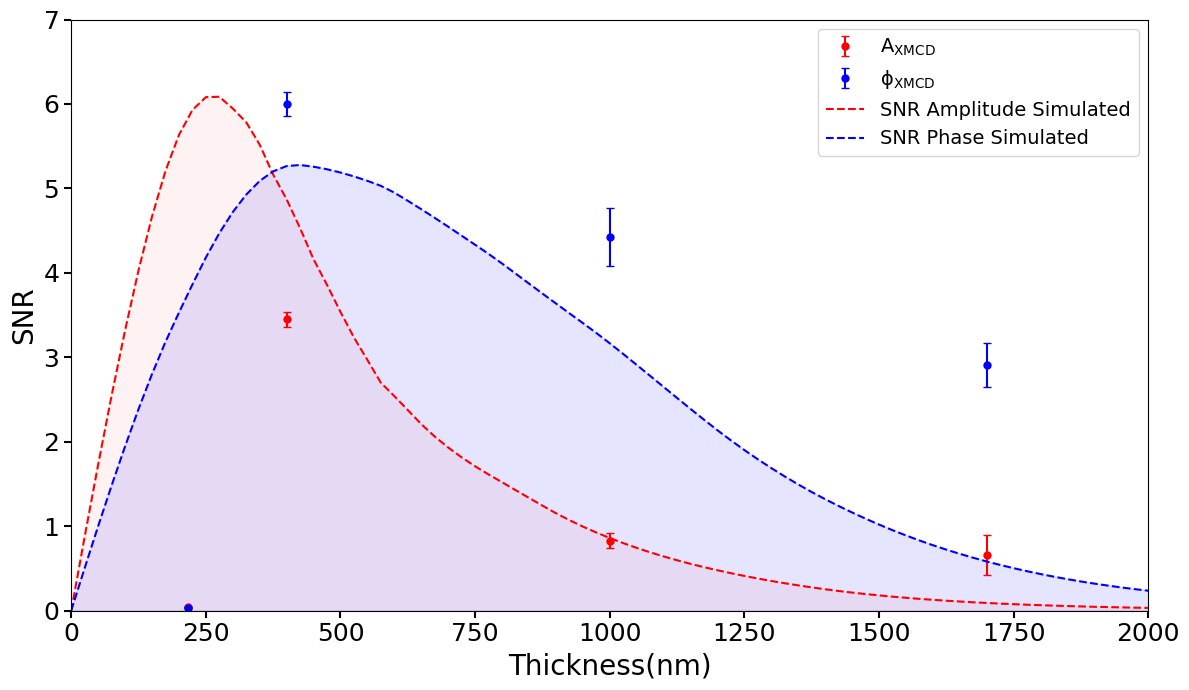

In [140]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))

p1 = ax.errorbar(mix_thickness[:], mix_SNR_measured_amp, yerr=mix_snr_err_amp, color='red', marker='.', linestyle='', capsize=3, ecolor='red', label='A$\mathrm{_{XMCD}}$', alpha=1, markersize=10)

p2 = ax.errorbar(mix_thickness[:], mix_SNR_measured_phase, yerr=mix_snr_err_phase, color='blue', marker='.', linestyle='', capsize=3, ecolor='blue', label='$\mathrm{\phi_{XMCD}}$', alpha=1, markersize=10)


thickness_multiplier = 2.5
signal_multiplier_amp = 1
signal_multiplier_phase = 1

p3, = ax.plot(thickness_multiplier*thickness_simulated, interp_max_sim_amp_xmcd_rcp*signal_multiplier_amp, color='red',ls='--', label='SNR Amplitude Simulated') #previous value was 0.42
ax.fill_betweenx(interp_max_sim_amp_xmcd_rcp*signal_multiplier_amp,thickness_multiplier*thickness_simulated, color='red', alpha=0.05)


p4, = ax.plot(thickness_multiplier*thickness_simulated, interp_max_sim_phase_xmcd_rcp*signal_multiplier_phase, color='blue', ls='--', label='SNR Phase Simulated') #previous value was 0.42
ax.fill_betweenx(interp_max_sim_phase_xmcd_rcp*signal_multiplier_phase,thickness_multiplier*thickness_simulated, color='blue', alpha=0.1)
line_meet = np.argwhere(np.diff(np.sign(interp_max_sim_amp_xmcd_rcp - interp_max_sim_phase_xmcd_rcp))).flatten()
tkw = dict(size=5, width=1.5, labelsize=18)
ax.tick_params(axis='y', **tkw)
ax.tick_params(axis='x', **tkw)

ax.set_xlim(0,2000)
ax.set_ylim(0,7)

ax.set_xlabel('Thickness(nm)',fontsize=20)
ax.set_ylabel('SNR',fontsize=20)


ax.legend(handles=[p1,p2,p3,p4], fontsize=14)
plt.tight_layout()

plt.show()

In [1]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(18,10))
fig.subplots_adjust(right=1)

twin1 = ax.twinx()
twin2 = ax.twinx()


twin2.spines.right.set_position(("axes", 1.1))

p1, = ax.plot(rcp_energy, rcp_absorption*100, color='k', ls="-", label="Transmission")
p2 = twin1.errorbar(rcp_energy, -log_amp_avg_spec*100, yerr=split_avg_amp_error[:,0]*100, color='red', marker='.', linestyle=':', capsize=3, ecolor='red', label='A$\mathrm{_{XMCD}}$', alpha=1, markersize=10)
p3 = twin2.errorbar(rcp_energy, -phase_avg_spec, yerr=split_avg_phase_error[:,0], color='blue', marker='.', linestyle=':', capsize=3, ecolor='blue', label='$\mathrm{\phi_{XMCD}}$', alpha=1, markersize=10)

ax.set_xlim(770,807)



ax.set_ylim(0, 67)
twin1.set_ylim(-24, 11.9)
twin2.set_ylim(-0.2,0.1)




ax.set_xlabel("Energy (eV)", fontsize=24)
ax.set_ylabel("Transmission (%)", fontsize=24)
twin1.set_ylabel("A$\mathrm{_{XMCD}}$ (%)", fontsize=28)
twin2.set_ylabel("$\mathrm{\phi_{XMCD}}$ (rad)", fontsize=28)


twin1.axhline(0, color='gray', ls='--', alpha=0.5)


ax.fill_between(rcp_energy[2:17], rcp_absorption[2:17]*100, color='blue', alpha=0.1)
ax.fill_between(rcp_energy[34:73], rcp_absorption[34:73]*100, color='blue', alpha=0.1)
ax.fill_between(rcp_energy[100:105], rcp_absorption[100:105]*100, color='blue', alpha=0.1)
ax.fill_between(rcp_energy[16:35], rcp_absorption[16:35]*100, color='red', alpha=0.1)
ax.fill_between(rcp_energy[72:101], rcp_absorption[72:101]*100, color='red', alpha=0.1)


ax.yaxis.label.set_color('k')
twin1.yaxis.label.set_color('red')
twin2.yaxis.label.set_color('blue')


tkw = dict(size=5, width=1.5, labelsize=24)
ax.tick_params(axis='y', colors='k', **tkw)
twin1.tick_params(axis='y', colors='red', **tkw)
twin2.tick_params(axis='y', colors='blue', **tkw)
ax.tick_params(axis='x', **tkw)
plt.title('XMCD Spectra')
ax.legend(handles=[p1, p2, p3], fontsize=22) #, p4, p5
plt.tight_layout()

plt.show()

NameError: name 'plt' is not defined

In [161]:
scaling_factor = 1 
amp_sigma_1d_filter=4
pos_rcp_abs_elec_xmcd = gaussian_filter(scaling_factor * pos_amp_rcp_elec_xmcd_spectra**2,amp_sigma_1d_filter)
neg_rcp_abs_elec_xmcd = gaussian_filter(scaling_factor * neg_amp_rcp_elec_xmcd_spectra**2,amp_sigma_1d_filter)
pos_lcp_abs_elec_xmcd = gaussian_filter(scaling_factor * pos_amp_lcp_elec_xmcd_spectra**2,amp_sigma_1d_filter)
neg_lcp_abs_elec_xmcd = gaussian_filter(scaling_factor * neg_amp_lcp_elec_xmcd_spectra**2,amp_sigma_1d_filter)


interp_energy = np.arange(770,807,0.005)
interp_pos_rcp_abs_elec_xmcd = np.interp(interp_energy, rcp_energy, pos_rcp_abs_elec_xmcd)
interp_neg_rcp_abs_elec_xmcd = np.interp(interp_energy, rcp_energy, neg_rcp_abs_elec_xmcd)
interp_pos_lcp_abs_elec_xmcd = np.interp(interp_energy, rcp_energy, pos_lcp_abs_elec_xmcd)
interp_neg_lcp_abs_elec_xmcd = np.interp(interp_energy, rcp_energy, neg_lcp_abs_elec_xmcd)

interp_mu_pos_rcp_100nm = -(np.log(interp_pos_rcp_abs_elec_xmcd)/(100*1e-9))
interp_mu_neg_rcp_100nm = -(np.log(interp_neg_rcp_abs_elec_xmcd)/(100*1e-9))
interp_mu_pos_lcp_100nm = -(np.log(interp_pos_lcp_abs_elec_xmcd)/(100*1e-9))
interp_mu_neg_lcp_100nm = -(np.log(interp_neg_lcp_abs_elec_xmcd)/(100*1e-9))


def detection_limit_amp(data1, data2):
    """ For two polarisation
    limit: sets what the detector can detect. For example if detector can detect 0.5% transmission set limit to 0.005"""
    tmp1 = data1
    tmp2 = data2
    limit = 0.0000000005
    
    for i in range (0, len(tmp1)):
        for j in range (0, len(tmp1[i])):
            if tmp1[i,j] < np.log(limit) and tmp2[i,j] < np.log(limit):
                tmp1[i,j] = 0
                tmp2[i,j] = 0
    return tmp1, tmp2



def interp_sim_abs(n, pol='rcp', domain = 'pos' ):
    if pol == 'rcp' and domain == 'pos':
        return (-interp_mu_pos_rcp_100nm * n * 1e-9)
    elif pol == 'rcp' and domain == 'neg':
        return (-interp_mu_neg_rcp_100nm * n * 1e-9)
    elif pol == 'lcp' and domain == 'pos':
        return (-interp_mu_pos_lcp_100nm * n * 1e-9)
    elif pol == 'lcp' and domain == 'neg':
        return (-interp_mu_neg_lcp_100nm * n * 1e-9)
    else:
        raise Exception('pol can only be \'lcp\' or \'rcp\' and domain can only be \'pos\' or \'neg\'. Default is rcp and pos')

starting_thickness = 0
ending_thickness = 8000
step_size=20

thickness_simulated = np.arange(starting_thickness, ending_thickness,step_size)
interp_sim_amp_rcp_pos = np.asarray([interp_sim_abs(i, pol='rcp', domain='pos') for i in np.arange(starting_thickness, ending_thickness, step_size)])
interp_sim_amp_rcp_neg = np.asarray([interp_sim_abs(i, pol='rcp', domain='neg') for i in np.arange(starting_thickness, ending_thickness, step_size)])
interp_sim_amp_lcp_pos= np.asarray([interp_sim_abs(i, pol='lcp', domain='pos') for i in np.arange(starting_thickness, ending_thickness, step_size)])
interp_sim_amp_lcp_neg = np.asarray([interp_sim_abs(i, pol='lcp', domain='neg') for i in np.arange(starting_thickness, ending_thickness, step_size)])

# Imposing detection limit

interp_sim_amp_rcp_pos, interp_sim_amp_rcp_neg = detection_limit_amp(interp_sim_amp_rcp_pos, interp_sim_amp_rcp_neg)
interp_sim_amp_lcp_pos, interp_sim_amp_lcp_neg = detection_limit_amp(interp_sim_amp_lcp_pos, interp_sim_amp_lcp_neg)



interp_sim_amp_xmcd_rcp = (((interp_sim_amp_rcp_pos) - (interp_sim_amp_rcp_neg))/4)
interp_sim_amp_xmcd = (((interp_sim_amp_rcp_pos) - (interp_sim_amp_lcp_neg))/4)

interp_wavelength = h*c*1e9/(interp_energy*e)
interp_k = 2*pi/interp_wavelength

scaling_factor=4.5

phase_sigma_1d_filter = 1

filtered_pos_phase_rcp_elec_xmcd_spectra = gaussian_filter(scaling_factor * pos_phase_rcp_elec_xmcd_spectra, phase_sigma_1d_filter)
filtered_neg_phase_rcp_elec_xmcd_spectra = gaussian_filter(scaling_factor * neg_phase_rcp_elec_xmcd_spectra, phase_sigma_1d_filter)
filtered_pos_phase_lcp_elec_xmcd_spectra = gaussian_filter(scaling_factor * pos_phase_lcp_elec_xmcd_spectra, phase_sigma_1d_filter)
filtered_neg_phase_lcp_elec_xmcd_spectra = gaussian_filter(scaling_factor * neg_phase_lcp_elec_xmcd_spectra, phase_sigma_1d_filter)

interp_pos_phase_rcp_elec_xmcd_spectra = np.interp(interp_energy, rcp_energy, filtered_pos_phase_rcp_elec_xmcd_spectra)
interp_neg_phase_rcp_elec_xmcd_spectra = np.interp(interp_energy, rcp_energy, filtered_neg_phase_rcp_elec_xmcd_spectra)
interp_pos_phase_lcp_elec_xmcd_spectra = np.interp(interp_energy, rcp_energy, filtered_pos_phase_lcp_elec_xmcd_spectra)
interp_neg_phase_lcp_elec_xmcd_spectra = np.interp(interp_energy, rcp_energy, filtered_neg_phase_lcp_elec_xmcd_spectra)



interp_delta_pos_rcp = interp_pos_phase_rcp_elec_xmcd_spectra * interp_wavelength / (2 * pi * 100 * 1e-9)
interp_delta_neg_rcp = interp_neg_phase_rcp_elec_xmcd_spectra * interp_wavelength / (2 * pi * 100 * 1e-9)
interp_delta_pos_lcp = interp_pos_phase_lcp_elec_xmcd_spectra * interp_wavelength / (2 * pi * 100 * 1e-9)
interp_delta_neg_lcp = interp_neg_phase_lcp_elec_xmcd_spectra * interp_wavelength / (2 * pi * 100 * 1e-9)

def interp_sim_phi_elec_xmcd(n, pol='rcp', domain='pos'):
    if pol == 'rcp' and domain== 'pos':
        return interp_delta_pos_rcp * interp_k * n * 1e-9
    elif pol == 'rcp' and domain == 'neg':
        return interp_delta_neg_rcp * interp_k * n * 1e-9
    elif pol == 'lcp' and domain == 'pos':
        return interp_delta_pos_lcp * interp_k * n * 1e-9
    elif pol == 'lcp' and domain == 'neg':
        return interp_delta_neg_lcp * interp_k * n * 1e-9
    else:
        raise Exception('pol can only be \'lcp\' or \'rcp\' and domain can only be \'pos\' or \'neg\'. Default is rcp and pos')
        
        
interp_sim_phase_rcp_pos = np.asarray([interp_sim_phi_elec_xmcd(i, pol='rcp', domain='pos') for i in np.arange(starting_thickness, ending_thickness, step_size)])
interp_sim_phase_rcp_neg = np.asarray([interp_sim_phi_elec_xmcd(i, pol='rcp', domain='neg') for i in np.arange(starting_thickness, ending_thickness, step_size)])
interp_sim_phase_lcp_pos = np.asarray([interp_sim_phi_elec_xmcd(i, pol='lcp', domain='pos') for i in np.arange(starting_thickness, ending_thickness, step_size)])
interp_sim_phase_lcp_neg = np.asarray([interp_sim_phi_elec_xmcd(i, pol='lcp', domain='neg') for i in np.arange(starting_thickness, ending_thickness, step_size)])
interp_sim_phase_rcp_xmcd = (interp_sim_phase_rcp_pos - interp_sim_phase_rcp_neg)/2
interp_sim_phase_lcp_xmcd = (interp_sim_phase_lcp_pos - interp_sim_phase_lcp_neg)/2

interp_sim_phase_xmcd = (interp_sim_phase_rcp_pos - interp_sim_phase_lcp_neg)/2
mask_phase_from_transmission = np.abs(interp_sim_amp_rcp_pos) > 0
interp_transmission_sim_phase_xmcd = interp_sim_phase_rcp_xmcd * mask_phase_from_transmission

d1 = []
d2 = []
d3 = []
for i in range(0,len(interp_transmission_sim_phase_xmcd)):
    t1 = np.max(np.abs(interp_transmission_sim_phase_xmcd[i]))
    d1.append(t1)
    t2 = np.argmax(np.abs(interp_transmission_sim_phase_xmcd[i]))
    d2.append(t2)
    d3.append(interp_energy[t2])
interp_max_sim_phase_xmcd_rcp = np.asarray(d1)
interp_index_max_sim_phase_xmcd_rcp = np.asarray(d2)
interp_energy_max_sim_phase_xmcd_rcp = np.asarray(d3)

scaling_factor = 1 
amp_sigma_1d_filter=4
pos_rcp_abs_elec_xmcd = gaussian_filter(scaling_factor * pos_amp_rcp_elec_xmcd_spectra**2,amp_sigma_1d_filter)
neg_rcp_abs_elec_xmcd = gaussian_filter(scaling_factor * neg_amp_rcp_elec_xmcd_spectra**2,amp_sigma_1d_filter)
pos_lcp_abs_elec_xmcd = gaussian_filter(scaling_factor * pos_amp_lcp_elec_xmcd_spectra**2,amp_sigma_1d_filter)
neg_lcp_abs_elec_xmcd = gaussian_filter(scaling_factor * neg_amp_lcp_elec_xmcd_spectra**2,amp_sigma_1d_filter)


interp_energy = np.arange(770,807,0.005)
interp_pos_rcp_abs_elec_xmcd = np.interp(interp_energy, rcp_energy, pos_rcp_abs_elec_xmcd)
interp_neg_rcp_abs_elec_xmcd = np.interp(interp_energy, rcp_energy, neg_rcp_abs_elec_xmcd)
interp_pos_lcp_abs_elec_xmcd = np.interp(interp_energy, rcp_energy, pos_lcp_abs_elec_xmcd)
interp_neg_lcp_abs_elec_xmcd = np.interp(interp_energy, rcp_energy, neg_lcp_abs_elec_xmcd)

interp_mu_pos_rcp_100nm = -(np.log(interp_pos_rcp_abs_elec_xmcd)/(100*1e-9))
interp_mu_neg_rcp_100nm = -(np.log(interp_neg_rcp_abs_elec_xmcd)/(100*1e-9))
interp_mu_pos_lcp_100nm = -(np.log(interp_pos_lcp_abs_elec_xmcd)/(100*1e-9))
interp_mu_neg_lcp_100nm = -(np.log(interp_neg_lcp_abs_elec_xmcd)/(100*1e-9))

def detection_limit_amp(data1, data2):
    """ For two polarisation
    limit: sets what the detector can detect. For example if detector can detect 0.5% transmission set limit to 0.005"""
    tmp1 = data1
    tmp2 = data2
    limit = 0.0000000005
    
    for i in range (0, len(tmp1)):
        for j in range (0, len(tmp1[i])):
            if tmp1[i,j] < np.log(limit) and tmp2[i,j] < np.log(limit):
                tmp1[i,j] = 0
                tmp2[i,j] = 0
    return tmp1, tmp2


def interp_sim_abs(n, pol='rcp', domain = 'pos' ):
    if pol == 'rcp' and domain == 'pos':
        return (-interp_mu_pos_rcp_100nm * n * 1e-9)
    elif pol == 'rcp' and domain == 'neg':
        return (-interp_mu_neg_rcp_100nm * n * 1e-9)
    elif pol == 'lcp' and domain == 'pos':
        return (-interp_mu_pos_lcp_100nm * n * 1e-9)
    elif pol == 'lcp' and domain == 'neg':
        return (-interp_mu_neg_lcp_100nm * n * 1e-9)
    else:
        raise Exception('pol can only be \'lcp\' or \'rcp\' and domain can only be \'pos\' or \'neg\'. Default is rcp and pos')

        
thickness_simulated = np.arange(starting_thickness, ending_thickness,step_size)
interp_sim_amp_rcp_pos = np.asarray([interp_sim_abs(i, pol='rcp', domain='pos') for i in np.arange(starting_thickness, ending_thickness, step_size)])
interp_sim_amp_rcp_neg = np.asarray([interp_sim_abs(i, pol='rcp', domain='neg') for i in np.arange(starting_thickness, ending_thickness, step_size)])
interp_sim_amp_lcp_pos= np.asarray([interp_sim_abs(i, pol='lcp', domain='pos') for i in np.arange(starting_thickness, ending_thickness, step_size)])
interp_sim_amp_lcp_neg = np.asarray([interp_sim_abs(i, pol='lcp', domain='neg') for i in np.arange(starting_thickness, ending_thickness, step_size)])

# Imposing detection limit

interp_sim_amp_rcp_pos, interp_sim_amp_rcp_neg = detection_limit_amp(interp_sim_amp_rcp_pos, interp_sim_amp_rcp_neg)
interp_sim_amp_lcp_pos, interp_sim_amp_lcp_neg = detection_limit_amp(interp_sim_amp_lcp_pos, interp_sim_amp_lcp_neg)

interp_sim_amp_xmcd_rcp = (((interp_sim_amp_rcp_pos) - (interp_sim_amp_rcp_neg))/4)
interp_sim_amp_xmcd = (((interp_sim_amp_rcp_pos) - (interp_sim_amp_lcp_neg))/4)

interp_wavelength = h*c*1e9/(interp_energy*e)
interp_k = 2*pi/interp_wavelength

scaling_factor=4.5


phase_sigma_1d_filter = 1

filtered_pos_phase_rcp_elec_xmcd_spectra = gaussian_filter(scaling_factor * pos_phase_rcp_elec_xmcd_spectra, phase_sigma_1d_filter)
filtered_neg_phase_rcp_elec_xmcd_spectra = gaussian_filter(scaling_factor * neg_phase_rcp_elec_xmcd_spectra, phase_sigma_1d_filter)
filtered_pos_phase_lcp_elec_xmcd_spectra = gaussian_filter(scaling_factor * pos_phase_lcp_elec_xmcd_spectra, phase_sigma_1d_filter)
filtered_neg_phase_lcp_elec_xmcd_spectra = gaussian_filter(scaling_factor * neg_phase_lcp_elec_xmcd_spectra, phase_sigma_1d_filter)

interp_pos_phase_rcp_elec_xmcd_spectra = np.interp(interp_energy, rcp_energy, filtered_pos_phase_rcp_elec_xmcd_spectra)
interp_neg_phase_rcp_elec_xmcd_spectra = np.interp(interp_energy, rcp_energy, filtered_neg_phase_rcp_elec_xmcd_spectra)
interp_pos_phase_lcp_elec_xmcd_spectra = np.interp(interp_energy, rcp_energy, filtered_pos_phase_lcp_elec_xmcd_spectra)
interp_neg_phase_lcp_elec_xmcd_spectra = np.interp(interp_energy, rcp_energy, filtered_neg_phase_lcp_elec_xmcd_spectra)



interp_delta_pos_rcp = interp_pos_phase_rcp_elec_xmcd_spectra * interp_wavelength / (2 * pi * 100 * 1e-9)
interp_delta_neg_rcp = interp_neg_phase_rcp_elec_xmcd_spectra * interp_wavelength / (2 * pi * 100 * 1e-9)
interp_delta_pos_lcp = interp_pos_phase_lcp_elec_xmcd_spectra * interp_wavelength / (2 * pi * 100 * 1e-9)
interp_delta_neg_lcp = interp_neg_phase_lcp_elec_xmcd_spectra * interp_wavelength / (2 * pi * 100 * 1e-9)

def interp_sim_phi_elec_xmcd(n, pol='rcp', domain='pos'):
    if pol == 'rcp' and domain== 'pos':
        return interp_delta_pos_rcp * interp_k * n * 1e-9
    elif pol == 'rcp' and domain == 'neg':
        return interp_delta_neg_rcp * interp_k * n * 1e-9
    elif pol == 'lcp' and domain == 'pos':
        return interp_delta_pos_lcp * interp_k * n * 1e-9
    elif pol == 'lcp' and domain == 'neg':
        return interp_delta_neg_lcp * interp_k * n * 1e-9
    else:
        raise Exception('pol can only be \'lcp\' or \'rcp\' and domain can only be \'pos\' or \'neg\'. Default is rcp and pos')
        
        
interp_sim_phase_rcp_pos = np.asarray([interp_sim_phi_elec_xmcd(i, pol='rcp', domain='pos') for i in np.arange(starting_thickness, ending_thickness, step_size)])
interp_sim_phase_rcp_neg = np.asarray([interp_sim_phi_elec_xmcd(i, pol='rcp', domain='neg') for i in np.arange(starting_thickness, ending_thickness, step_size)])
interp_sim_phase_lcp_pos = np.asarray([interp_sim_phi_elec_xmcd(i, pol='lcp', domain='pos') for i in np.arange(starting_thickness, ending_thickness, step_size)])
interp_sim_phase_lcp_neg = np.asarray([interp_sim_phi_elec_xmcd(i, pol='lcp', domain='neg') for i in np.arange(starting_thickness, ending_thickness, step_size)])
interp_sim_phase_rcp_xmcd = (interp_sim_phase_rcp_pos - interp_sim_phase_rcp_neg)/2
interp_sim_phase_lcp_xmcd = (interp_sim_phase_lcp_pos - interp_sim_phase_lcp_neg)/2

interp_sim_phase_xmcd = (interp_sim_phase_rcp_pos - interp_sim_phase_lcp_neg)/2
mask_phase_from_transmission = np.abs(interp_sim_amp_rcp_pos) > 0
interp_transmission_sim_phase_xmcd = interp_sim_phase_rcp_xmcd * mask_phase_from_transmission

d1 = []
d2 = []
d3 = []
for i in range(0,len(interp_transmission_sim_phase_xmcd)):
    t1 = np.max(np.abs(interp_transmission_sim_phase_xmcd[i]))
    d1.append(t1)
    t2 = np.argmax(np.abs(interp_transmission_sim_phase_xmcd[i]))
    d2.append(t2)
    d3.append(interp_energy[t2])
interp_max_sim_phase_xmcd_rcp = np.asarray(d1)
interp_index_max_sim_phase_xmcd_rcp = np.asarray(d2)
interp_energy_max_sim_phase_xmcd_rcp = np.asarray(d3)


mask_phase_from_transmission = np.abs(interp_sim_amp_rcp_pos) > 0

interp_transmission_sim_phase_xmcd = interp_sim_phase_rcp_xmcd * mask_phase_from_transmission

d1 = []
d2 = []
d3 = []
for i in range(0,len(interp_transmission_sim_phase_xmcd)):
    t1 = np.max(np.abs(interp_transmission_sim_phase_xmcd[i]))
    d1.append(t1)
    t2 = np.argmax(np.abs(interp_transmission_sim_phase_xmcd[i]))
    d2.append(t2)
    d3.append(interp_energy[t2])
interp_max_sim_phase_xmcd_rcp = np.asarray(d1)
interp_index_max_sim_phase_xmcd_rcp = np.asarray(d2)
interp_energy_max_sim_phase_xmcd_rcp = np.asarray(d3)

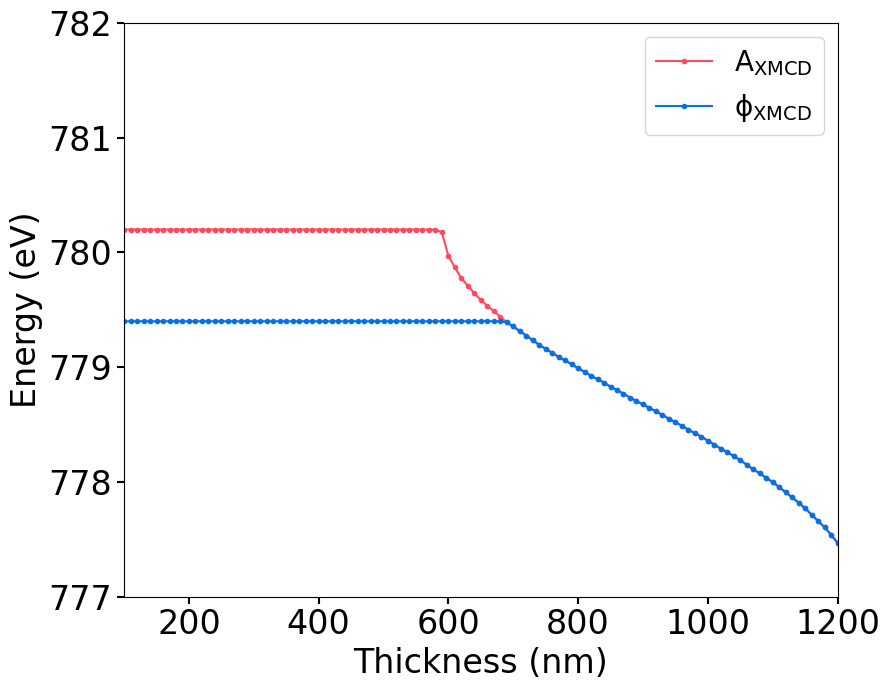

In [162]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(9,7))

p1, = ax.plot((thickness_simulated[1:])/2, copt_amp_energy_dependence, marker='.', ls='-', color='#ff495f', alpha=1, label='A$\mathrm{_{XMCD}}$')
p2, = ax.plot((thickness_simulated[1:])/2, interp_energy[interp_index_max_sim_phase_xmcd_rcp[1:]], marker='.', ls='-', color='#0173E9', alpha=1, label='$\mathrm{\phi_{XMCD}}$')

tkw = dict(size=5, width=1.5, labelsize=24)
ax.tick_params(axis='y', **tkw)

ax.tick_params(axis='x', **tkw)

ax.axes.get_xaxis().set_visible(True)

ax.set_xlabel('Thickness (nm)', fontsize=24)
ax.set_ylabel('Energy (eV)', fontsize=24)

ax.set_xlim(100,1200)
ax.set_ylim(777,782)

ax.legend(handles=[p1,p2], fontsize=20, loc='upper right')
plt.tight_layout()

plt.show()

In [163]:
amp_sigma_1d_filter=4
pos_rcp_abs_elec_xmcd = gaussian_filter(pos_amp_rcp_elec_xmcd_spectra**2,amp_sigma_1d_filter)
neg_rcp_abs_elec_xmcd = gaussian_filter(neg_amp_rcp_elec_xmcd_spectra**2,amp_sigma_1d_filter)
pos_lcp_abs_elec_xmcd = gaussian_filter(pos_amp_lcp_elec_xmcd_spectra**2,amp_sigma_1d_filter)
neg_lcp_abs_elec_xmcd = gaussian_filter(neg_amp_lcp_elec_xmcd_spectra**2,amp_sigma_1d_filter)


interp_energy = np.arange(770,807,0.005)
interp_pos_rcp_abs_elec_xmcd = np.interp(interp_energy, rcp_energy, pos_rcp_abs_elec_xmcd)
interp_neg_rcp_abs_elec_xmcd = np.interp(interp_energy, rcp_energy, neg_rcp_abs_elec_xmcd)
interp_pos_lcp_abs_elec_xmcd = np.interp(interp_energy, rcp_energy, pos_lcp_abs_elec_xmcd)
interp_neg_lcp_abs_elec_xmcd = np.interp(interp_energy, rcp_energy, neg_lcp_abs_elec_xmcd)

interp_mu_pos_rcp_100nm = -(np.log(interp_pos_rcp_abs_elec_xmcd)/(100*1e-9))
interp_mu_neg_rcp_100nm = -(np.log(interp_neg_rcp_abs_elec_xmcd)/(100*1e-9))
interp_mu_pos_lcp_100nm = -(np.log(interp_pos_lcp_abs_elec_xmcd)/(100*1e-9))
interp_mu_neg_lcp_100nm = -(np.log(interp_neg_lcp_abs_elec_xmcd)/(100*1e-9))


def detection_limit_amp(data1, data2):
    """ For two polarisation
    limit: sets what the detector can detect. For example if detector can detect 0.5% transmission set limit to 0.005"""
    tmp1 = data1
    tmp2 = data2
    limit = 0.0000000005
    for i in range (0, len(tmp1)):
        for j in range (0, len(tmp1[i])):
            if tmp1[i,j] < np.log(limit) and tmp2[i,j] < np.log(limit):
                tmp1[i,j] = -23 # -23 since we are on logarithmic units. 0 means 1 transmission
                tmp2[i,j] = -23
    return tmp1, tmp2


def interp_sim_abs(n, pol='rcp', domain = 'pos' ):
    if pol == 'rcp' and domain == 'pos':

        return (-interp_mu_pos_rcp_100nm * n * 1e-9)
    elif pol == 'rcp' and domain == 'neg':

        return (-interp_mu_neg_rcp_100nm * n * 1e-9)
    elif pol == 'lcp' and domain == 'pos':

        return (-interp_mu_pos_lcp_100nm * n * 1e-9)
    elif pol == 'lcp' and domain == 'neg':

        return (-interp_mu_neg_lcp_100nm * n * 1e-9)
    else:
        raise Exception('pol can only be \'lcp\' or \'rcp\' and domain can only be \'pos\' or \'neg\'. Default is rcp and pos')

starting_thickness = 0
ending_thickness = 8000
step_size=20

thickness_simulated = np.arange(starting_thickness, ending_thickness,step_size)
interp_sim_amp_rcp_pos = np.asarray([interp_sim_abs(i, pol='rcp', domain='pos') for i in np.arange(starting_thickness, ending_thickness, step_size)])
interp_sim_amp_rcp_neg = np.asarray([interp_sim_abs(i, pol='rcp', domain='neg') for i in np.arange(starting_thickness, ending_thickness, step_size)])
interp_sim_amp_lcp_pos= np.asarray([interp_sim_abs(i, pol='lcp', domain='pos') for i in np.arange(starting_thickness, ending_thickness, step_size)])
interp_sim_amp_lcp_neg = np.asarray([interp_sim_abs(i, pol='lcp', domain='neg') for i in np.arange(starting_thickness, ending_thickness, step_size)])

# Imposing detection limit

interp_sim_amp_rcp_pos, interp_sim_amp_rcp_neg = detection_limit_amp(interp_sim_amp_rcp_pos, interp_sim_amp_rcp_neg)
interp_sim_amp_lcp_pos, interp_sim_amp_lcp_neg = detection_limit_amp(interp_sim_amp_lcp_pos, interp_sim_amp_lcp_neg)

interp_sim_amp_xmcd_rcp = (((interp_sim_amp_rcp_pos) - (interp_sim_amp_rcp_neg))/4)
interp_sim_amp_xmcd = (((interp_sim_amp_rcp_pos) - (interp_sim_amp_lcp_neg))/4)

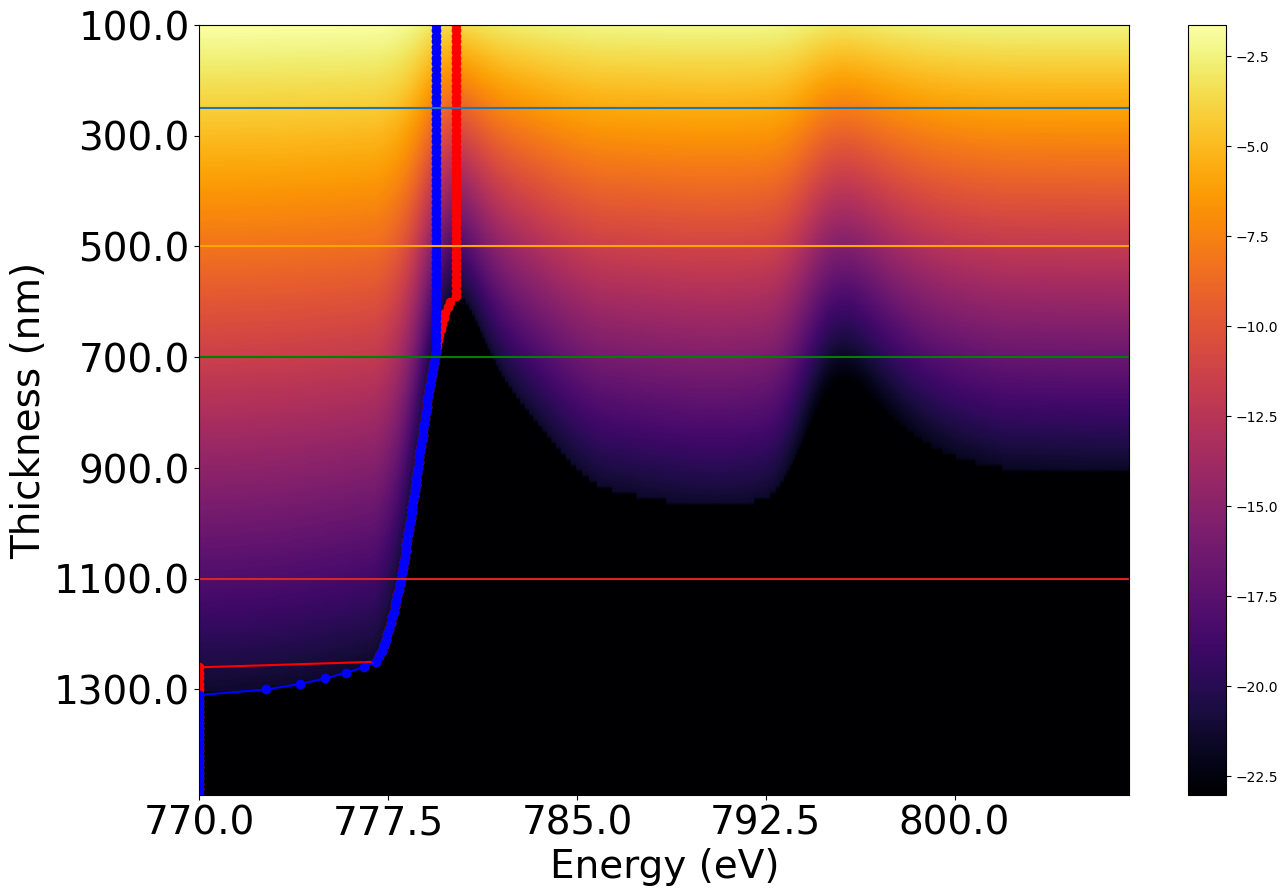

In [166]:
%matplotlib inline
x_tick_locations = np.arange(0, len(interp_energy), 1500)
energy_label = np.around(interp_energy[x_tick_locations], decimals=1)
y_tick_locations=np.arange(0,len(thickness_simulated),20)
thickness_label=np.around(thickness_simulated[y_tick_locations], decimals=0)
fig,ax = plt.subplots(figsize=(15,10))
im1 = ax.imshow((interp_sim_amp_rcp_pos[10:,10:]), cmap='inferno', aspect='auto', interpolation='antialiased', interpolation_stage='data', alpha=1)
ax.set_xticks(ticks=x_tick_locations, labels=energy_label, fontsize=28)
ax.set_xlabel('Energy (eV)', fontsize=28)
ax.set_yticks(ticks=y_tick_locations, labels=thickness_label/2 +100, fontsize=28)
ax.set_ylabel('Thickness (nm)', fontsize=28)

plt.colorbar(im1,ax=ax)
plt.plot(interp_index_max_sim_amp_xmcd_rcp[10:], np.arange(0,len(thickness_simulated)-10,1), marker='o', ls='-', color='red', alpha=1)
plt.plot(interp_index_max_sim_phase_xmcd_rcp[10:], np.arange(0,len(thickness_simulated)-10,1),marker='o', ls='-', color='blue', alpha=1)
plt.axhline(15, ls='-', color='tab:blue', alpha=1)
plt.axhline(40, ls='-', color='orange', alpha=1)
plt.axhline(60, ls='-', color='green', alpha=1)
plt.axhline(100, ls='-', color='tab:red', alpha=1)
ax.set_ylim(139,0)

# plt.savefig(r'/Users/jn/Desktop/Paper_Preparation/Final_Figures/new_Figure3/benedikt_comment_transmission_vs_thickness_inferno.pdf', bbox_inches='tight')
plt.show()

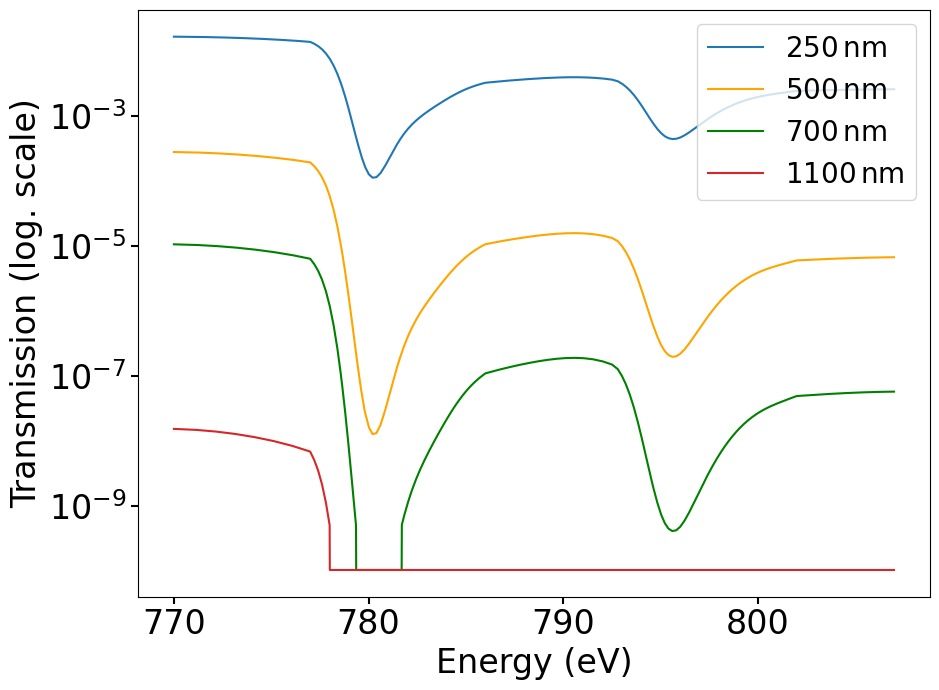

In [167]:
plt.close()
fig, ax = plt.subplots(figsize=(9.5,7))
fig.subplots_adjust(right=1)

ax.yaxis.get_ticklocs(minor=True) 
ax.set_ylabel("Transmission (log. scale)",fontsize=24)
ax.set_xlabel("Energy (eV)",fontsize=24)

ax.plot(interp_energy, np.exp((interp_sim_amp_rcp_pos[15+10])), color='tab:blue',label='%d$\,$nm'%(thickness_simulated[15+10]/2))
ax.plot(interp_energy, np.exp((interp_sim_amp_rcp_pos[40+10])), color='orange',label='%d$\,$nm'%(thickness_simulated[40+10]/2))
ax.plot(interp_energy, np.exp((interp_sim_amp_rcp_pos[60+10])), color='green',label='%d$\,$nm'%(thickness_simulated[60+10]/2))
ax.plot(interp_energy, np.exp((interp_sim_amp_rcp_pos[100+10])), color='tab:red',label='%d$\,$nm'%(thickness_simulated[100+10]/2))
ax.set_yscale('log')


plt.legend(fontsize=20, loc='upper right')
tkw = dict(size=5, width=1.5, labelsize=24)
ax.tick_params(axis='y', **tkw)
ax.tick_params(axis='x', **tkw)
plt.tight_layout()
# plt.savefig(r'/Users/jn/Desktop/Paper_Preparation/Final_Figures/new_Figure3/final_new_select_sim_transmission_final.pdf', bbox_inches='tight')
plt.show()




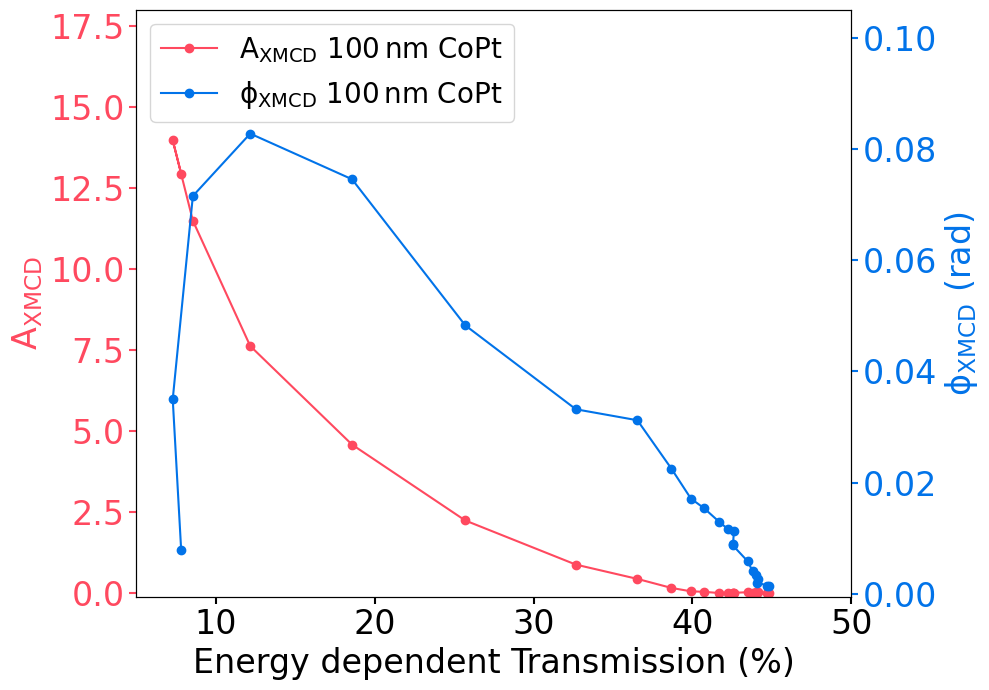

In [168]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,7))

p1, = ax.plot((rcp_absorption[:23])*100, np.abs(log_amp_avg_spec[:23])*100, color='#FF495F', label='$\mathrm{A_{XMCD}}$ 100$\,$nm CoPt', marker='o', ls='-')
twin1 = ax.twinx()
p2, = twin1.plot((rcp_absorption[:23])*100, np.abs(phase_avg_spec[:23]), color='#0173E9', label='$\mathrm{\phi_{XMCD}}$ 100$\,$nm CoPt', marker='o', ls='-')

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())

tkw = dict(size=5, width=1.5, labelsize=24)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax.axes.get_xaxis().set_visible(True)
ax.set_xlabel('Energy dependent Transmission (%)', fontsize=24)
ax.set_ylabel('$\mathrm{A_{XMCD}}$', fontsize=24)
twin1.set_ylabel('$\mathrm{\phi_{XMCD}}$ (rad)', fontsize=24)
ax.set_xlim(5,50)
ax.set_ylim(-0.001*100,0.18*100)
twin1.set_ylim(-0.0005,0.105)
ax.legend(handles=[p1,p2], fontsize=20, loc='upper left')
plt.tight_layout()
# plt.savefig(r'/Users/jn/Desktop/PhD//Paper_Preparation/Pre-edge_XMCD_Ptycho_PRX/Resubmission_2//Figures/Fig_3/pre-edge_signal_transmission_bigger_.pdf', bbox_inches='tight')
plt.show()

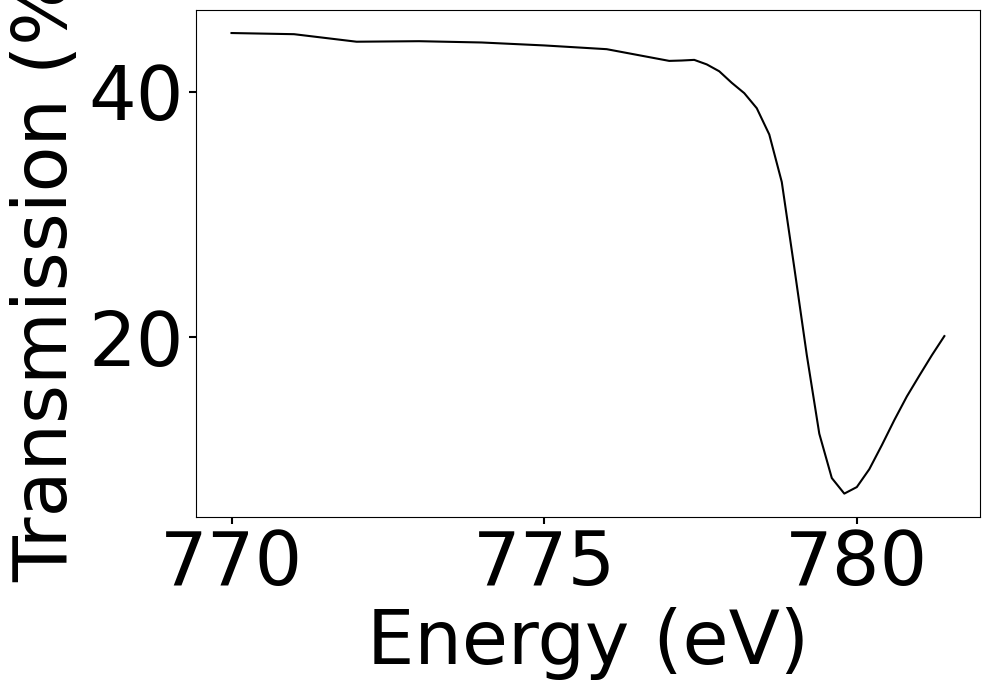

In [169]:
%matplotlib inline
plt.close()
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,7))

p1, = ax.plot((rcp_energy[:30]), rcp_absorption[:30]*100, color='k', marker='', ls='-')

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())

tkw = dict(size=5, width=1.5, labelsize=54)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax.axes.get_xaxis().set_visible(True)
ax.set_xlabel('Energy (eV)', fontsize=54)
ax.set_ylabel('Transmission (%)', fontsize=54)
plt.tight_layout()
# plt.savefig(r'/Users/jn/Desktop/Paper_Preparation/Final_Figures/new_Figure3/pre-edge_EvsT.pdf', bbox_inches='tight')
plt.show()

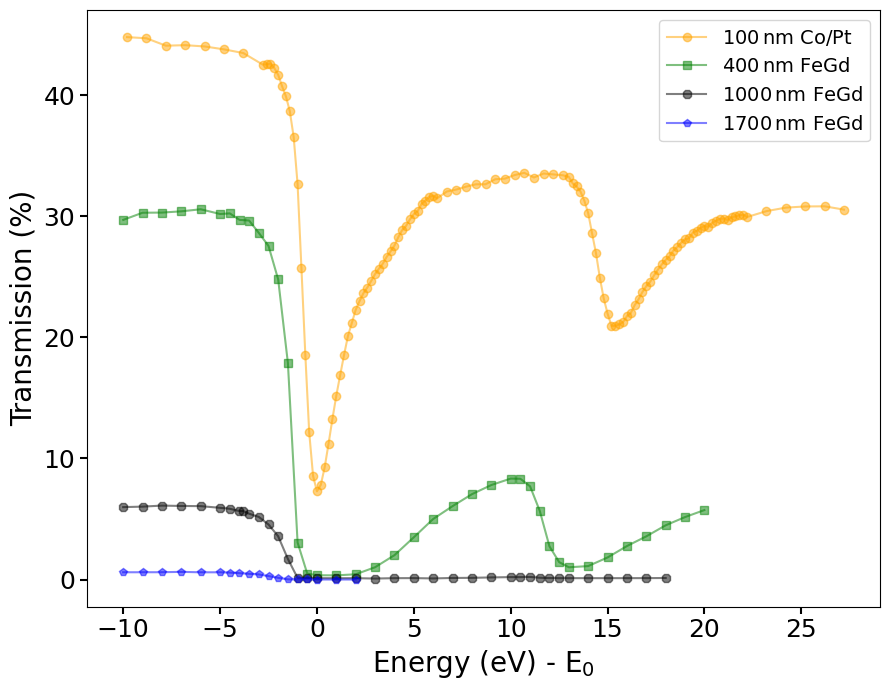

In [170]:
plt.close()
fig, ax = plt.subplots(figsize=(9,7))
fig.subplots_adjust(right=1)
norm_1000nm_transmission = transmission_1000nm * 0.06/np.mean(transmission_1000nm[0:2])
norm_400nm_transmission = transmission_400nm * 0.3/np.mean(transmission_400nm[0:2])


ax.set_ylabel("Transmission (%)",fontsize=20)
ax.set_xlabel("Energy (eV) - E$_0$",fontsize=20)
ax.plot(rcp_energy-779.8, (rcp_absorption)*100, color='orange', marker = 'o', label = '100$\,$nm Co/Pt', linestyle = '-', alpha=0.5)
ax.plot(energy_400nm - 710 , norm_400nm_transmission*100, color='g', marker = 's', label='400$\,$nm FeGd', linestyle = '-', alpha=0.5)
ax.plot(energy_1000nm - 710 , norm_1000nm_transmission*100, color='k', marker = '8', label='1000$\,$nm FeGd', linestyle = '-', alpha=0.5)
ax.plot(energy_1700nm - 710 , transmission_1700nm*100, color='b', marker = 'p', label='1700$\,$nm FeGd', linestyle = '-', alpha=0.5)


plt.legend(fontsize=14, loc='upper right')

tkw = dict(size=5, width=1.5, labelsize=18)
ax.tick_params(axis='y', **tkw)
ax.tick_params(axis='x', **tkw)

plt.tight_layout()
# plt.savefig(r'/Users/jn/Desktop/Paper_Preparation/Final_Figures/new_Figure4/all_transmission_final.pdf', bbox_inches='tight')
plt.show()




##  Spatial Resolution

### FRC

##### Amplitude

In [39]:
pixelsize = 17.414
img1 = log_rcp_amp_xmcd[23]
img2 = log_rcp_amp_xmcd[22]
frc_test = fourier_shell_correlation.FourierShellCorr(img1, img2,ring_thick=6, rad_apod=60, axial_apod=20)
y1 = frc_test.fouriercorr()
x1 = frc_test.nyquist()

Input images have 2 dimensions
Using ring_thick = 6
Using SNRt = 0.2071


##### Interpolated

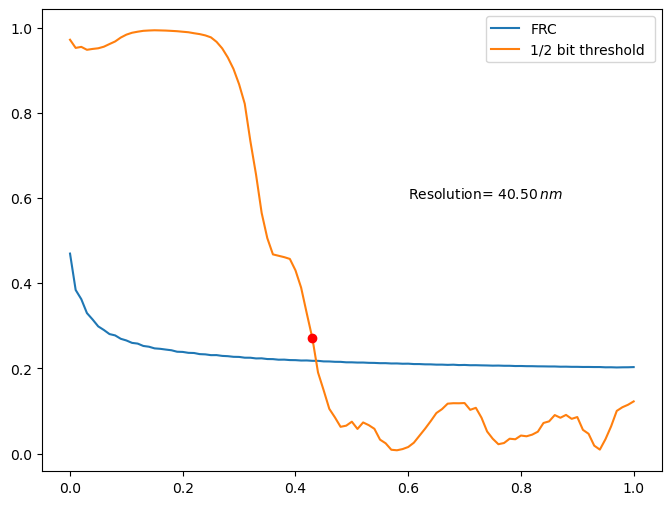

In [40]:
%matplotlib inline

tmp = np.argwhere(np.diff(np.sign(y1[0] - y1[1]))).flatten()
x = x1[0]/x1[1]
resolution = pixelsize / x[tmp[0]]
plt.close()
plt.plot(x1[0]/x1[1], y1[1], label='FRC')
plt.plot(x1[0]/x1[1], y1[0], label='1/2 bit threshold ')
plt.plot(x[tmp[0]], y1[0][tmp[0]], 'ro')
plt.text(0.6,0.6,'Resolution= %.2f$\,nm$'%(resolution))
# plt.title('Amplitude resonance RCP')
plt.legend()
plt.show()

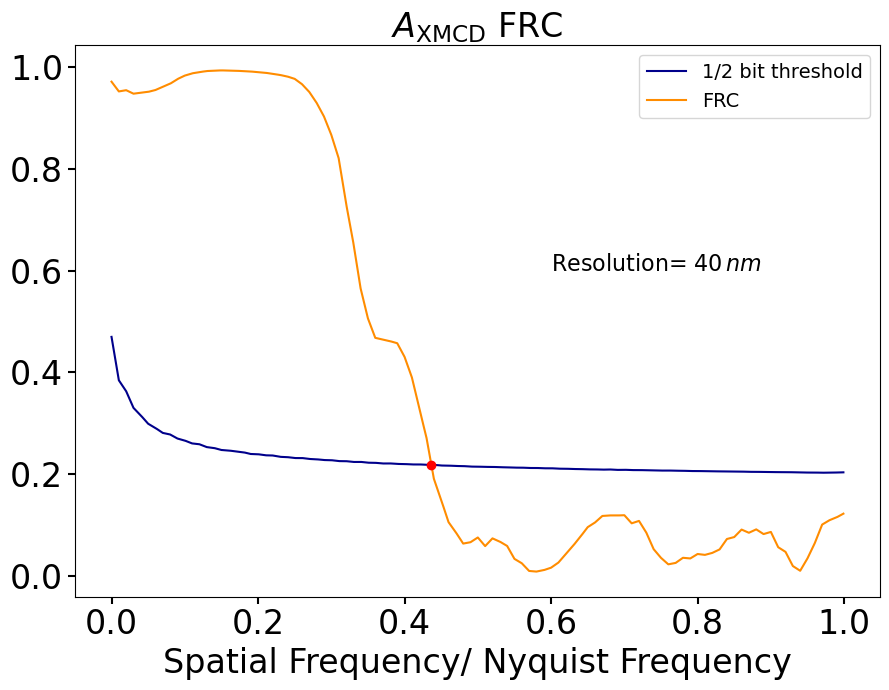

In [44]:
x_interp = np.arange(0,1,0.001)
y1_0_interp = np.interp(x_interp, x, y1[1])
y1_1_interp = np.interp(x_interp, x, y1[0])


tmp_interp = np.argwhere(np.diff(np.sign(y1_0_interp - y1_1_interp))).flatten()
resolution = pixelsize / x_interp[tmp_interp[0]]

# plt.close()
# plt.plot(x_interp, y1_0_interp)
# plt.plot(x_interp, y1_1_interp)
# plt.plot(x_interp[tmp_interp[0]], y1_0_interp[tmp_interp[0]], 'ro')
# plt.text(0.6,0.6,'Resolution= %.2f$\,nm$'%(resolution),fontsize=16)


plt.close()
fig, ax = plt.subplots(figsize=(9,7))
fig.subplots_adjust(right=1)

ax.set_xlabel("Spatial Frequency/ Nyquist Frequency",fontsize=24)
ax.plot(x_interp, y1_0_interp, label='1/2 bit threshold', color='darkblue')
ax.plot(x_interp, y1_1_interp, label='FRC',color = 'darkorange')
ax.plot(x_interp[tmp_interp[0]], y1_0_interp[tmp_interp[0]], 'ro')
ax.text(0.6,0.6,'Resolution= %d$\,nm$'%(np.round(resolution)),fontsize=16)
# ax.text(0.6,0.6,'Resolution= %.2f$\,nm$'%(resolution),fontsize=16)

tkw = dict(size=5, width=1.5, labelsize=24)
ax.tick_params(axis='y', **tkw)
ax.tick_params(axis='x', **tkw)
plt.legend(fontsize=14)
plt.title('$A_\mathrm{XMCD}$ FRC',fontsize=24)
plt.tight_layout()
plt.savefig(r'/Users/jn/Desktop/PhD/Paper_Preparation/Pre-edge_XMCD_Ptycho_PRX/Figures/Final_Figures/Appendix_spatial_res/proof_FRC_amplitude_ring_thick_6.pdf', bbox_inches='tight')
plt.show()




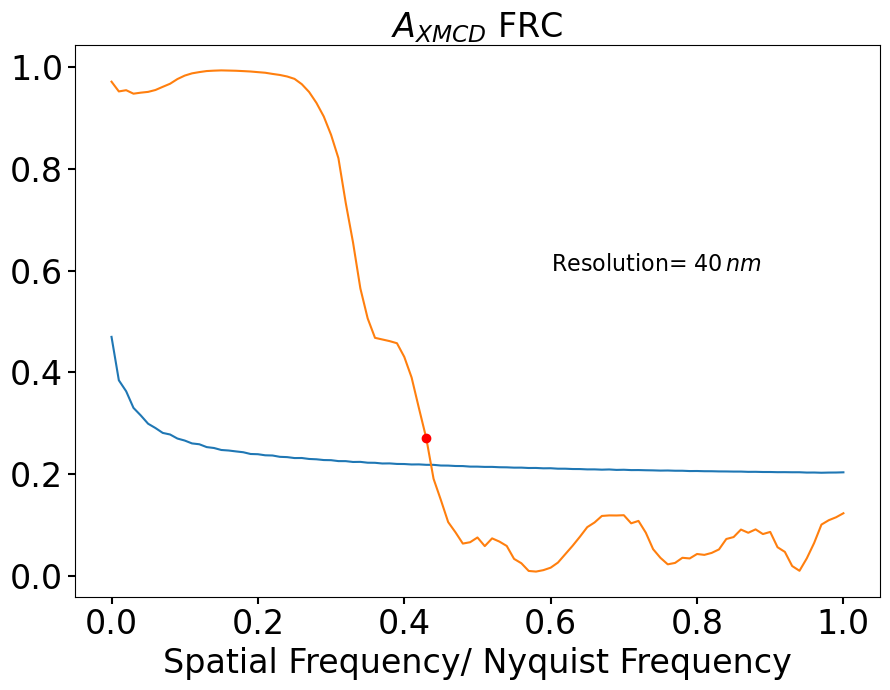

In [28]:
plt.close()
fig, ax = plt.subplots(figsize=(9,7))
fig.subplots_adjust(right=1)

ax.set_xlabel("Spatial Frequency/ Nyquist Frequency",fontsize=24)
ax.plot(x1[0]/x1[1], y1[1], label='FRC')
ax.plot(x1[0]/x1[1], y1[0], label='1/2 bit threshold ')
ax.plot(x[tmp[0]], y1[0][tmp[0]], 'ro')
# ax.text(0.6,0.6,'Resolution= %.2f$\,nm$'%(resolution),fontsize=16)
ax.text(0.6,0.6,'Resolution= %d$\,nm$'%(np.round(resolution)),fontsize=16)
tkw = dict(size=5, width=1.5, labelsize=24)
ax.tick_params(axis='y', **tkw)
ax.tick_params(axis='x', **tkw)

plt.title('$A_{XMCD}$ FRC',fontsize=24)
plt.tight_layout()
# plt.savefig(r'/Users/jn/Desktop/Paper_Preparation/Final_Figures/Appendix_spatial_res/FRC_amplitude.pdf', bbox_inches='tight')
plt.show()




##### Phase

In [45]:
img1 = rcp_phase_xmcd[18]
img2 = rcp_phase_xmcd[19]
frc_test = fourier_shell_correlation.FourierShellCorr(img1, img2,ring_thick=6, rad_apod=60, axial_apod=20)
y1 = frc_test.fouriercorr()
x1 = frc_test.nyquist()

Input images have 2 dimensions
Using ring_thick = 6
Using SNRt = 0.2071


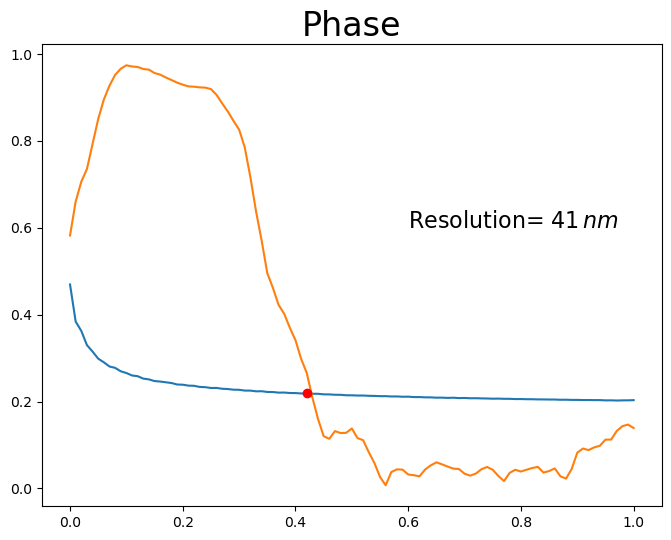

In [46]:
%matplotlib inline
i=0
tmp = np.argwhere(np.diff(np.sign(y1[0] - y1[1]))).flatten()
x = x1[0]/x1[1]
resolution = pixelsize / x[tmp[i]]
plt.close()
plt.plot(x1[0]/x1[1], y1[1])
plt.plot(x1[0]/x1[1], y1[0])
plt.plot(x[tmp[i]], y1[1][tmp[i]], 'ro')
# plt.text(0.6,0.6,'Resolution= %.2f$\,nm$'%(resolution))
plt.text(0.6,0.6,'Resolution= %d$\,nm$'%(np.round(resolution)),fontsize=16)
plt.title('Phase',fontsize=24)
plt.show()

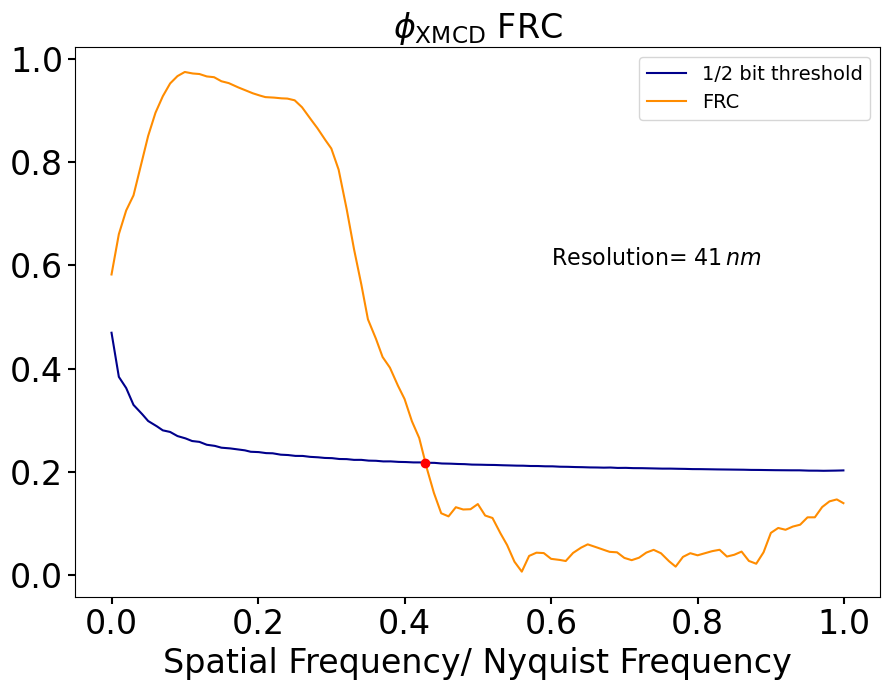

In [47]:
x_interp = np.arange(0,1,0.001)
y1_0_interp = np.interp(x_interp, x, y1[1])
y1_1_interp = np.interp(x_interp, x, y1[0])


tmp_interp = np.argwhere(np.diff(np.sign(y1_0_interp - y1_1_interp))).flatten()
resolution = pixelsize / x_interp[tmp_interp[0]]

# plt.close()
# plt.plot(x_interp, y1_0_interp)
# plt.plot(x_interp, y1_1_interp)
# plt.plot(x_interp[tmp_interp[0]], y1_0_interp[tmp_interp[0]], 'ro')
# plt.text(0.6,0.6,'Resolution= %.2f$\,nm$'%(resolution),fontsize=16)


plt.close()
fig, ax = plt.subplots(figsize=(9,7))
fig.subplots_adjust(right=1)

ax.set_xlabel("Spatial Frequency/ Nyquist Frequency",fontsize=24)
ax.plot(x_interp, y1_0_interp, label='1/2 bit threshold', color='darkblue')
ax.plot(x_interp, y1_1_interp, label='FRC', color='darkorange')
ax.plot(x_interp[tmp_interp[0]], y1_0_interp[tmp_interp[0]], 'ro')
# ax.text(0.6,0.6,'Resolution= %.2f$\,nm$'%(resolution),fontsize=16)
ax.text(0.6,0.6,'Resolution= %d$\,nm$'%(np.round(resolution)),fontsize=16)

tkw = dict(size=5, width=1.5, labelsize=24)
ax.tick_params(axis='y', **tkw)
ax.tick_params(axis='x', **tkw)
plt.legend(fontsize=14)
plt.title('$\phi_\mathrm{XMCD}$ FRC',fontsize=24)
plt.tight_layout()
plt.savefig(r'/Users/jn/Desktop/PhD/Paper_Preparation/Pre-edge_XMCD_Ptycho_PRX/Figures//Final_Figures/Appendix_spatial_res/proof_FRC_phase_ring_thick_6.pdf', bbox_inches='tight')
plt.show()




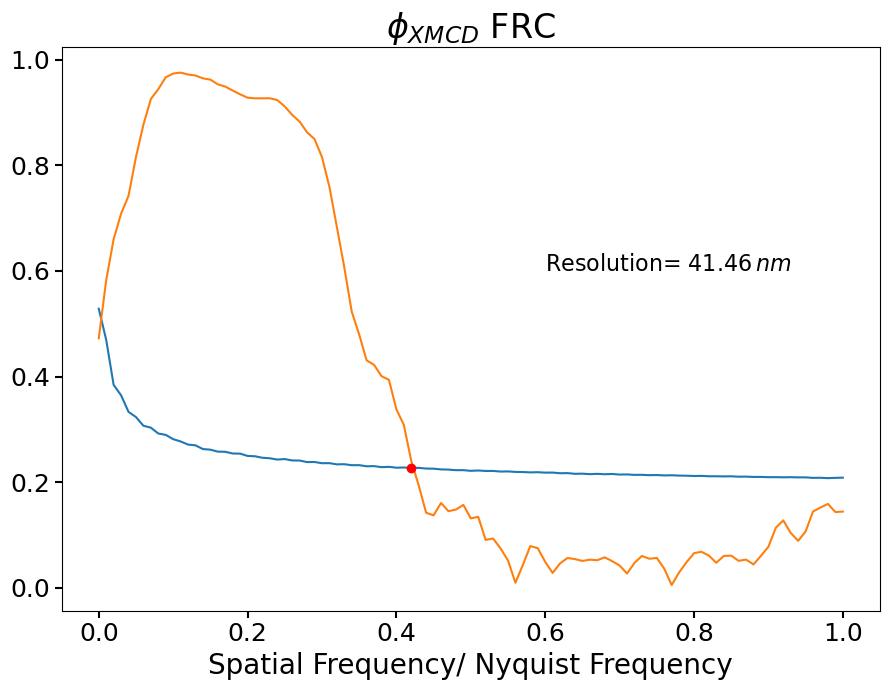

In [53]:
plt.close()
fig, ax = plt.subplots(figsize=(9,7))
fig.subplots_adjust(right=1)
# norm_1000nm_transmission = transmission_1000nm * 0.06/np.mean(transmission_1000nm[0:2])

# twin1 = ax.twiny()

ax.set_xlabel("Spatial Frequency/ Nyquist Frequency",fontsize=20)
# ax.set_ylabel("Noise",fontsize=20)
ax.plot(x1[0]/x1[1], y1[1], label='FRC')
ax.plot(x1[0]/x1[1], y1[0], label='1/2 bit threshold ')
ax.plot(x[tmp[1]], y1[1][tmp[1]], 'ro')
ax.text(0.6,0.6,'Resolution= %.2f$\,nm$'%(resolution),fontsize=16)

tkw = dict(size=5, width=1.5, labelsize=18)
ax.tick_params(axis='y', **tkw)
# twin1.tick_params(axis='y', colors='r', **tkw)
ax.tick_params(axis='x', **tkw)
# twin1.tick_params(axis='x', **tkw)

# plt.fill_between(rcp_energy[0:60], -log_amp_avg_spec[0:60], alpha=0.5, color='skyblue')
# plt.fill_between(rcp_energy[60:], -log_amp_avg_spec[60:], alpha=0.5, color='skyblue')
plt.title('$\phi_{XMCD}$ FRC',fontsize=24)
plt.tight_layout()
# plt.savefig(r'/Users/jn/Desktop/Paper_Preparation/Final_Figures/Appendix_spatial_res/FRC_phase.pdf', bbox_inches='tight')
plt.show()


